# Session-Based Recommendation System for E-commerce: A Comparative Study of Algorithmic Approaches to Product Matching

# Dataset

A portion of the entire dataset available on Kaggle at the link below (specifically, the first 12 hours of data from an entire month's worth) has been uploaded to Drive.

Link kaggle: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/data?select=2019-Oct.csv

Link Drive: https://docs.google.com/spreadsheets/d/1PYHX70EmmgRUt0RQ5OoGVR7_cF8niu7XLKyawu9ciKY/edit?gid=1572399804#gid=1572399804

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm

# Local path to the CSV file
file_path = "2019-10-01_Dataset.csv"

# Load the dataset
data = pd.read_csv(file_path)

# Count the number of rows in the dataset
row_count = data.shape[0]
print(f"Dataset has {row_count} rows.")

# Display the first 10 rows of the dataset
data.head(10)


ImportError: C extension: pandas.compat.numpy not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [ ]:
# Calculate the number of unique values and missing (NA) values for each requested field
unique_counts = {
    "event_time": (data["event_time"].nunique(), data["event_time"].isna().sum()),
    "event_type": (data["event_type"].nunique(), data["event_type"].isna().sum()),
    "product_id": (data["product_id"].nunique(), data["product_id"].isna().sum()),
    "category_id": (data["category_id"].nunique(), data["category_id"].isna().sum()),
    "category_code": (data["category_code"].nunique(), data["category_code"].isna().sum()),
    "brand": (data["brand"].nunique(), data["brand"].isna().sum()),
    "price": (data["price"].nunique(), data["price"].isna().sum()),
    "user_id": (data["user_id"].nunique(), data["user_id"].isna().sum()),
    "user_session": (data["user_session"].nunique(), data["user_session"].isna().sum())
}

# Convert to DataFrame for better visualization
unique_counts_df = pd.DataFrame(unique_counts.items(), columns=["Field", "Counts"])
unique_counts_df[["Unique Count", "Missing Count"]] = pd.DataFrame(unique_counts_df["Counts"].tolist(), index=unique_counts_df.index)
unique_counts_df = unique_counts_df.drop(columns=["Counts"])

# Display the table
unique_counts_df

,Field,Unique Count,Missing Count
0,event_time,35822,0
1,event_type,3,0
2,product_id,51188,0
3,category_id,541,0
4,category_code,123,191292
5,brand,2093,87492
6,price,14876,0
7,user_id,105887,0
8,user_session,141891,0



From the following chart, it is evident that users appear to be unusually active during nighttime hours. This is due to the fact that the data was collected from a country located in a time zone between GMT+4 and GMT+7

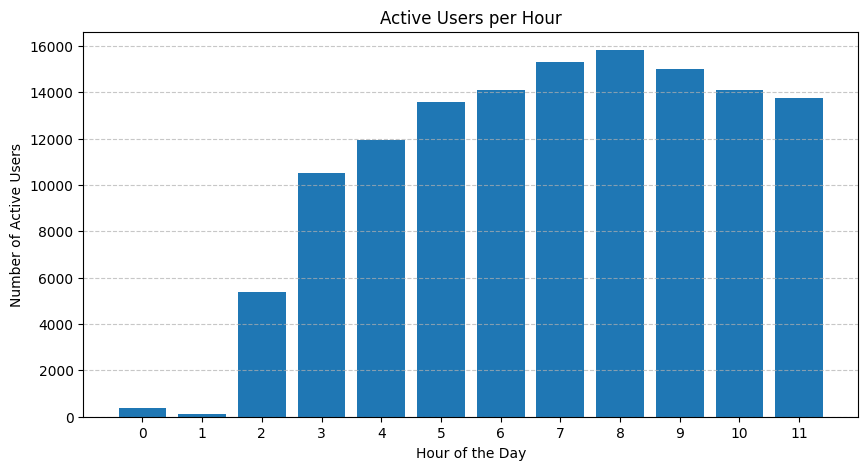

In [ ]:
# Create a copy of the dataset to avoid modifying the original data
df = data.copy()

# Ensure event_time is in datetime format
df['event_time'] = pd.to_datetime(df['event_time'])

# Extract the hour from event_time
df['hour'] = df['event_time'].dt.hour

# Count unique users per hour
user_counts_per_hour = df.groupby('hour')['user_id'].nunique()

# Plot the bar chart
plt.figure(figsize=(10, 5))
plt.bar(user_counts_per_hour.index, user_counts_per_hour.values)

# Labels and title
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Active Users")
plt.title("Active Users per Hour")
plt.xticks(range(min(user_counts_per_hour.index), max(user_counts_per_hour.index) + 1))  # Ensure all hours are shown
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

# Dataset cleaning

Process e-commerce session data by filtering relevant columns, formatting timestamps and prices, and calculating the time spent on each page per session using timestamp. Times spent on last pages of the session can't be calculated.


In [ ]:
# Filter the required columns with the correct names
columns_to_keep = ['event_time', 'event_type', 'category_id', 'category_code', 'product_id', 'brand', 'price', 'user_id', 'user_session']
sorted_data = data[columns_to_keep].sort_values(by=['user_session', 'event_time'])

# Create a copy of the dataset for manipulations
modified_data = sorted_data.copy()

# Ensure the 'event_time' column is in datetime format
modified_data['event_time'] = pd.to_datetime(modified_data['event_time'])

# Replace commas with dots in the 'price' column and ensure it is numeric
modified_data['price'] = modified_data['price'].str.replace(',', '.').astype(str)  # Replace commas with dots
modified_data['price'] = pd.to_numeric(modified_data['price'], errors='coerce')

# Calculate time spent on the page in seconds
modified_data['time_on_page'] = (
    modified_data.groupby('user_session')['event_time'].shift(-1) - modified_data['event_time']
).dt.total_seconds()

# For the last pages of the session, the duration remains NaN
modified_data.loc[modified_data.groupby('user_session')['event_time'].idxmax(), 'time_on_page'] = None

# Display the modified dataset
modified_data

,event_time,event_type,category_id,category_code,product_id,brand,price,user_id,user_session,time_on_page
465497,2019-10-01 09:51:44+00:00,view,2053013556311359947,construction.tools.drill,12300393,NaN,39.10,523769618,00016bb9-b50d-4bcb-95d1-9c375f214c66,30.0
466077,2019-10-01 09:52:14+00:00,view,2053013556311359947,construction.tools.drill,12300393,NaN,39.10,523769618,00016bb9-b50d-4bcb-95d1-9c375f214c66,NaN
485708,2019-10-01 10:09:56+00:00,view,2053013555631882655,electronics.smartphone,1003306,apple,587.53,513196971,0001d713-f9c4-4d96-8f8c-5da2bff7bbf9,67.0
486956,2019-10-01 10:11:03+00:00,view,2053013555631882655,electronics.smartphone,1004901,oppo,592.01,513196971,0001d713-f9c4-4d96-8f8c-5da2bff7bbf9,232.0
491234,2019-10-01 10:14:55+00:00,view,2053013561185141473,NaN,9600120,dji,132.57,513196971,0001d713-f9c4-4d96-8f8c-5da2bff7bbf9,98.0
...,...,...,...,...,...,...,...,...,...,...
529669,2019-10-01 10:49:57+00:00,view,2053013565748544479,apparel.shoes,28711588,caprice,32.18,552073878,fffc934b-54a2-4990-86fa-d2430c9ec52f,NaN
562520,2019-10-01 11:19:54+00:00,view,2053013561847841545,furniture.bedroom.blanket,23700097,askona,74.08,516335020,fffceee3-7369-4d8b-8c4b-692640052658,107.0
564543,2019-10-01 11:21:41+00:00,view,2053013563584283495,NaN,26300089,lucente,271.82,516335020,fffceee3-7369-4d8b-8c4b-692640052658,438.0
572383,2019-10-01 11:28:59+00:00,view,2053013559792632471,furniture.living_room.sofa,17200216,NaN,507.07,516335020,fffceee3-7369-4d8b-8c4b-692640052658,NaN



The analysis shows that most users within the same session view at least two different products. In some cases, users may pause and resume browsing in a new session, further increasing the proportion of users who view at least two products.

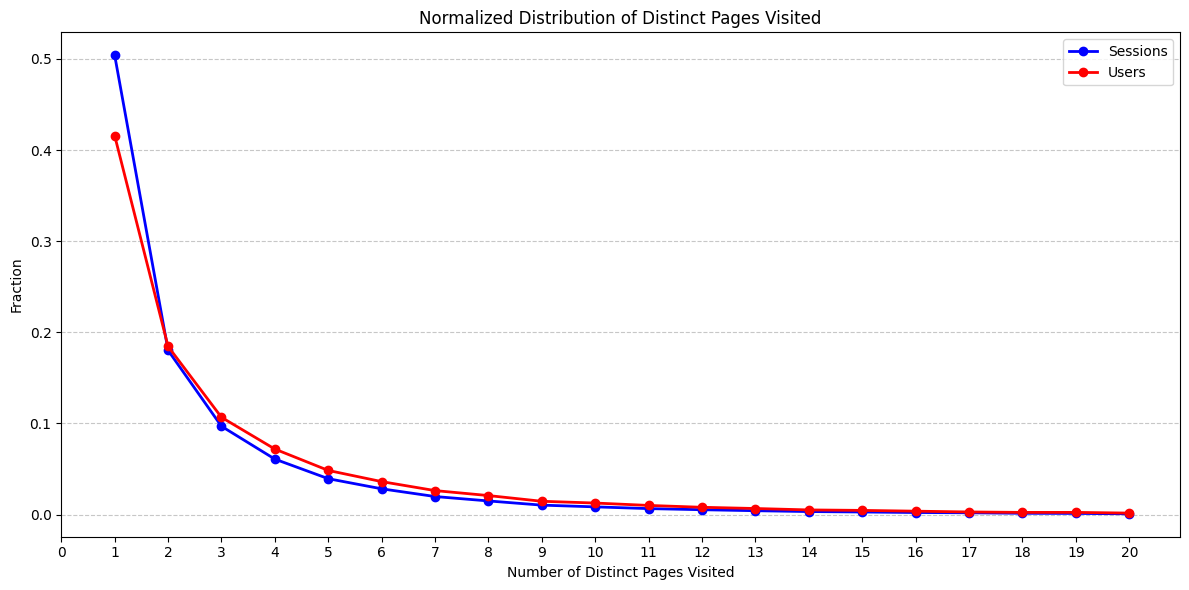

In [ ]:
# Count unique pages visited per session and per user
session_page_counts = modified_data.groupby('user_session')['product_id'].nunique()
user_page_counts = modified_data.groupby('user_id')['product_id'].nunique()

# Compute normalized distributions
session_distribution = session_page_counts.value_counts(normalize=True).sort_index()
user_distribution = user_page_counts.value_counts(normalize=True).sort_index()

# Limit to 0-20 distinct pages visited
session_distribution = session_distribution.loc[:20]
user_distribution = user_distribution.loc[:20]

# Plot distributions
plt.figure(figsize=(12, 6))
plt.plot(session_distribution.index, session_distribution.values, 'o-b', linewidth=2, label='Sessions')
plt.plot(user_distribution.index, user_distribution.values, 'o-r', linewidth=2, label='Users')

plt.title('Normalized Distribution of Distinct Pages Visited')
plt.xlabel('Number of Distinct Pages Visited')
plt.ylabel('Fraction')
plt.xticks(range(21))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

The time spent on individual pages is analyzed by summing the durations when the same page is viewed multiple times by the same user. Note that for the last page viewed in a session, the viewing time is unavailable.

The table has 379970 rows.


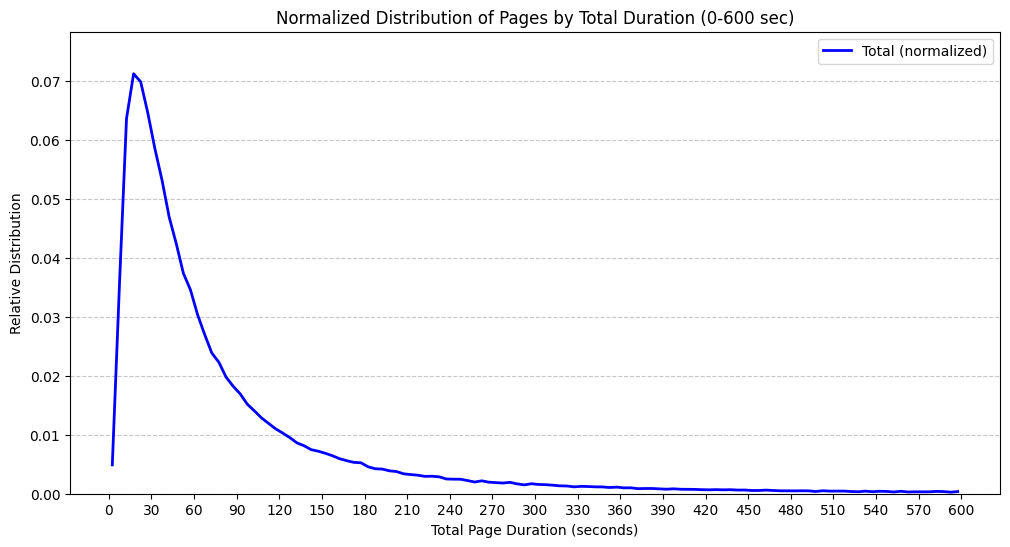

In [ ]:
# Group by user and product, summing total time on page
grouped_data = modified_data.groupby(['user_id', 'product_id'])['time_on_page'].sum().reset_index()

print(f"The table has {len(grouped_data)} rows.")

# Filter out non-positive values
filtered_data = grouped_data[grouped_data['time_on_page'] > 0]

# Compute histogram and normalize distribution
counts, bin_edges = np.histogram(filtered_data['time_on_page'], bins=120, range=(0, 600))
counts_normalized = counts / counts.sum() if counts.sum() > 0 else counts

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot distribution
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, counts_normalized, 'b-', linewidth=2, label='Total (normalized)')

# Configure plot
plt.title('Normalized Distribution of Pages by Total Duration (0-600 sec)')
plt.xlabel('Total Page Duration (seconds)')
plt.ylabel('Relative Distribution')
plt.xticks(np.arange(0, 601, 30))
plt.ylim(0, max(counts_normalized) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


Now, time distributions are analyzed based on the user’s interaction with each page. For example, if a page was viewed and later the product was added to the cart, it is recorded as a cart event. Similarly, purchases take priority over both views and cart events.

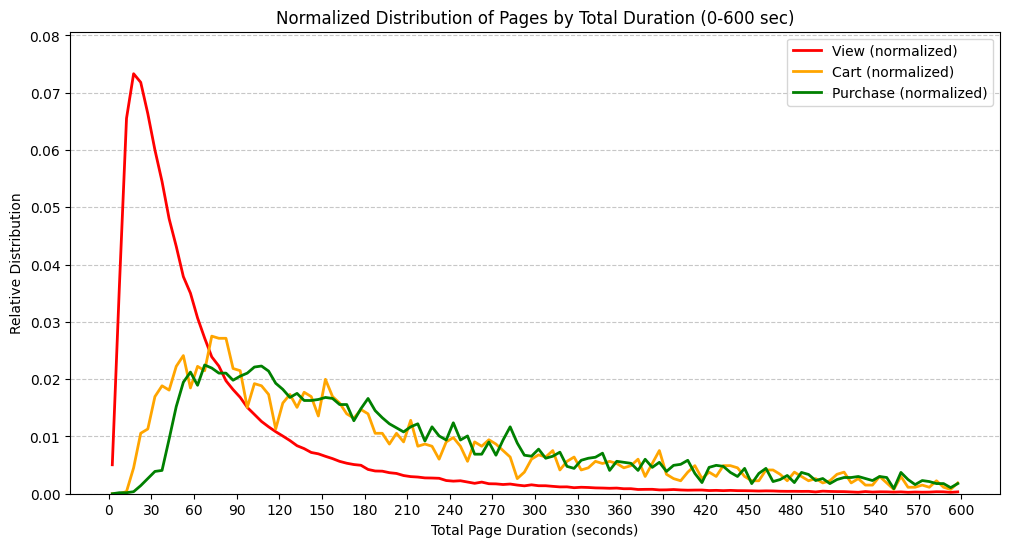

In [ ]:
# Assign priority to event types and drop null time_on_page values
event_priority = {'view': 1, 'cart': 2, 'purchase': 3}
modified_data = modified_data.dropna(subset=['time_on_page']).copy()
modified_data['event_priority'] = modified_data['event_type'].map(event_priority)

# Sum total time and select the highest-priority event type per (user_id, product_id)
grouped_data = (
    modified_data.sort_values('event_priority', ascending=False)
    .groupby(['user_id', 'product_id'])
    .agg(time_on_page=('time_on_page', 'sum'), event_type=('event_type', 'first'))
    .reset_index()
)

# Filter by event type
filtered = {etype: grouped_data[grouped_data['event_type'] == etype] for etype in ['view', 'cart', 'purchase']}

# Compute histograms and normalize distributions
bins, range_max = 120, 600
hist_data = {}
bin_edges = None  # To store edges for correct bin centers

for etype in filtered:
    counts, edges = np.histogram(filtered[etype]['time_on_page'], bins=bins, range=(0, range_max))
    hist_data[etype] = counts / counts.sum() if counts.sum() > 0 else counts
    bin_edges = edges  # Store edges from the last computed histogram

# Compute correct bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Plot distributions
plt.figure(figsize=(12, 6))
colors = {'view': 'red', 'cart': 'orange', 'purchase': 'green'}
for etype, color in colors.items():
    plt.plot(bin_centers, hist_data[etype], color=color, linewidth=2, label=f"{etype.capitalize()} (normalized)")

plt.title('Normalized Distribution of Pages by Total Duration (0-600 sec)')
plt.xlabel('Total Page Duration (seconds)')
plt.ylabel('Relative Distribution')
plt.xticks(np.arange(0, 601, 30))
plt.ylim(0, max(max(hist_data[etype]) for etype in hist_data) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()


Since cart and purchase have very similar distributions, and are very different from views, they are grouped together. This makes sense because they represent pages where the user actively interacted, showing the highest level of interest identifiable from these data.

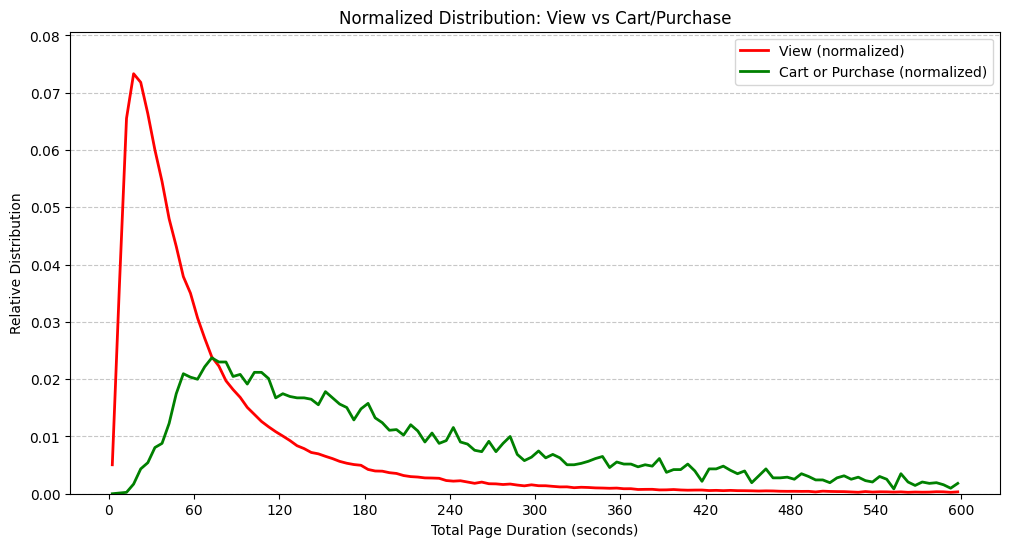

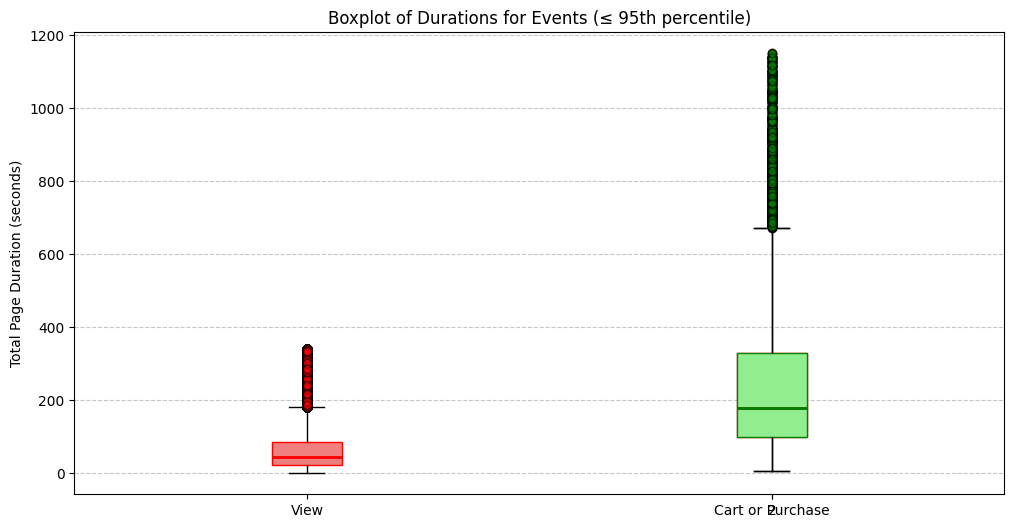

In [ ]:
# Combine 'cart' and 'purchase' into a single category
grouped_data['event_type_combined'] = grouped_data['event_type'].replace({'cart': 'cart_purchase', 'purchase': 'cart_purchase'})

# Filter data for 'view' and 'cart_purchase'
filtered = {etype: grouped_data[grouped_data['event_type_combined'] == etype] for etype in ['view', 'cart_purchase']}

# Compute histograms and normalize distributions
bins, range_max = 120, 600
hist_data, bin_edges = {}, None

for etype in filtered:
    counts, edges = np.histogram(filtered[etype]['time_on_page'], bins=bins, range=(0, range_max))
    hist_data[etype] = counts / counts.sum() if counts.sum() > 0 else counts
    bin_edges = edges  # Store edges for bin centers

# Compute bin centers
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Compute 95th percentile cutoffs for outlier removal
percentile_limits = {etype: np.percentile(filtered[etype]['time_on_page'].dropna(), 95) for etype in filtered}

# Filter out outliers
filtered_no_outliers = {
    etype: filtered[etype][filtered[etype]['time_on_page'] <= percentile_limits[etype]]
    for etype in filtered
}

# Prepare data for boxplot
boxplot_data = [filtered_no_outliers[etype]['time_on_page'].dropna() for etype in ['view', 'cart_purchase']]

# First Plot: Normalized Distribution
plt.figure(figsize=(12, 6))
plt.plot(bin_centers, hist_data['view'], 'r-', linewidth=2, label='View (normalized)')
plt.plot(bin_centers, hist_data['cart_purchase'], 'g-', linewidth=2, label='Cart or Purchase (normalized)')
plt.title('Normalized Distribution: View vs Cart/Purchase')
plt.xlabel('Total Page Duration (seconds)')
plt.ylabel('Relative Distribution')
plt.xticks(np.arange(0, 601, 60))
plt.ylim(0, max(hist_data['view'].max(), hist_data['cart_purchase'].max()) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Second Plot: Boxplot Without Outliers
plt.figure(figsize=(12, 6))
plt.boxplot(
    boxplot_data,
    tick_labels=['View', 'Cart or Purchase'],
    patch_artist=True,
    boxprops={'facecolor': 'lightcoral', 'color': 'red'},
    medianprops={'color': 'red', 'linewidth': 2},
    flierprops={'markerfacecolor': 'red', 'marker': 'o', 'alpha': 0.6}
)

plt.boxplot(
    [boxplot_data[1]],
    positions=[2],
    patch_artist=True,
    boxprops={'facecolor': 'lightgreen', 'color': 'green'},
    medianprops={'color': 'green', 'linewidth': 2},
    flierprops={'markerfacecolor': 'green', 'marker': 'o', 'alpha': 0.6}
)

plt.title('Boxplot of Durations for Events (≤ 95th percentile)')
plt.ylabel('Total Page Duration (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The level of interest and attention to product details by users might depend on the type of product, and more specifically, on its price range. This makes it intuitive to analyze how page visit durations vary across different price ranges, highlighting the importance of studying these distributions.

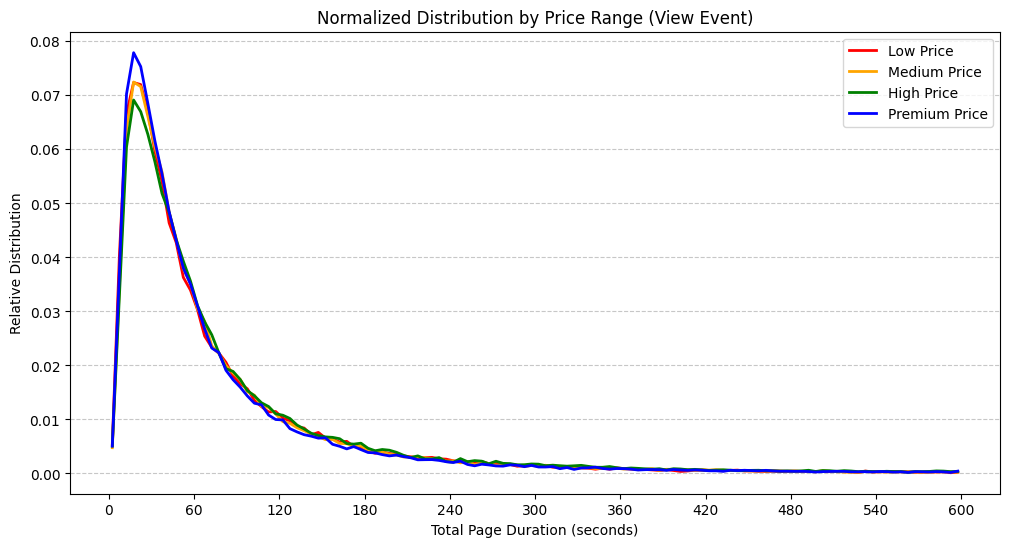

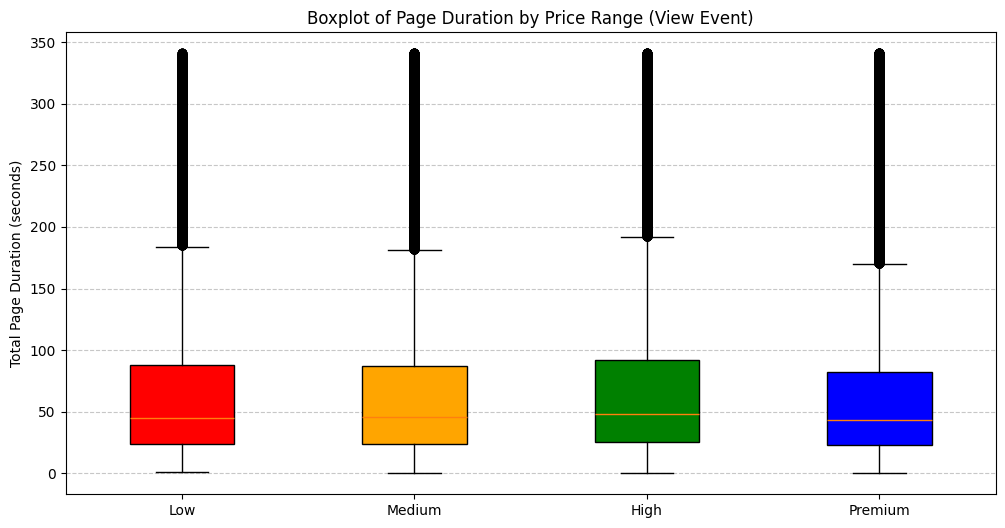

In [ ]:
# Sum total time per page, select highest-priority event, and calculate average price
grouped_data_price = (
    modified_data.sort_values('event_priority', ascending=False)
    .groupby(['user_id', 'product_id'])
    .agg(time_on_page=('time_on_page', 'sum'),
         event_type=('event_type', 'first'),
         price=('price', 'mean'))
    .reset_index()
)

# Combine 'cart' and 'purchase' into 'cart_purchase'
grouped_data_price['event_type_combined'] = grouped_data_price['event_type'].replace({'cart': 'cart_purchase', 'purchase': 'cart_purchase'})

# Filter 'view' event type
filtered_view_by_price = grouped_data_price[grouped_data_price['event_type_combined'] == 'view']

# Define price ranges and colors
price_ranges = {'Low': (0, 50), 'Medium': (50, 150), 'High': (150, 300), 'Premium': (300, np.inf)}
price_colors = {'Low': 'red', 'Medium': 'orange', 'High': 'green', 'Premium': 'blue'}

# Filter data by price range
filtered_views_by_price = {
    label: filtered_view_by_price[(filtered_view_by_price['price'] > bounds[0]) & (filtered_view_by_price['price'] <= bounds[1])]
    for label, bounds in price_ranges.items()
}

# First Plot: Normalized Distribution by Price Range
plt.figure(figsize=(12, 6))
for label, data in filtered_views_by_price.items():
    counts, bin_edges = np.histogram(data['time_on_page'], bins=120, range=(0, 600))
    counts = counts / counts.sum() if counts.sum() > 0 else counts
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, counts, label=f'{label} Price', linewidth=2, color=price_colors[label])

plt.title('Normalized Distribution by Price Range (View Event)')
plt.xlabel('Total Page Duration (seconds)')
plt.ylabel('Relative Distribution')
plt.xticks(np.arange(0, 601, 60))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Second Plot: Boxplot by Price Range (Excluding Outliers)
upper_threshold = np.percentile(filtered_view_by_price['time_on_page'].dropna(), 95)
filtered_upper_views_by_price = {
    label: data[data['time_on_page'] <= upper_threshold] for label, data in filtered_views_by_price.items()
}

plt.figure(figsize=(12, 6))
boxplots = plt.boxplot([data['time_on_page'].dropna() for data in filtered_upper_views_by_price.values()],
                       tick_labels=filtered_upper_views_by_price.keys(), patch_artist=True)

# Apply colors to boxplots
for patch, label in zip(boxplots['boxes'], filtered_upper_views_by_price.keys()):
    patch.set_facecolor(price_colors[label])

plt.title('Boxplot of Page Duration by Price Range (View Event)')
plt.ylabel('Total Page Duration (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Among the viewed pages, no significant differences are observed across price ranges. Similarly, for products added to the cart or purchased by users, the graphs below show no notable variations in page visit durations.

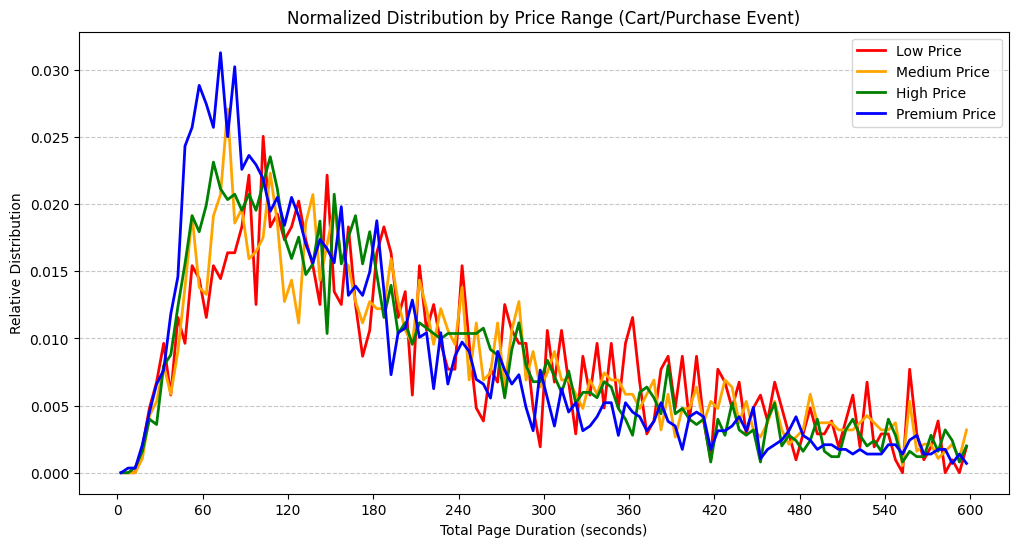

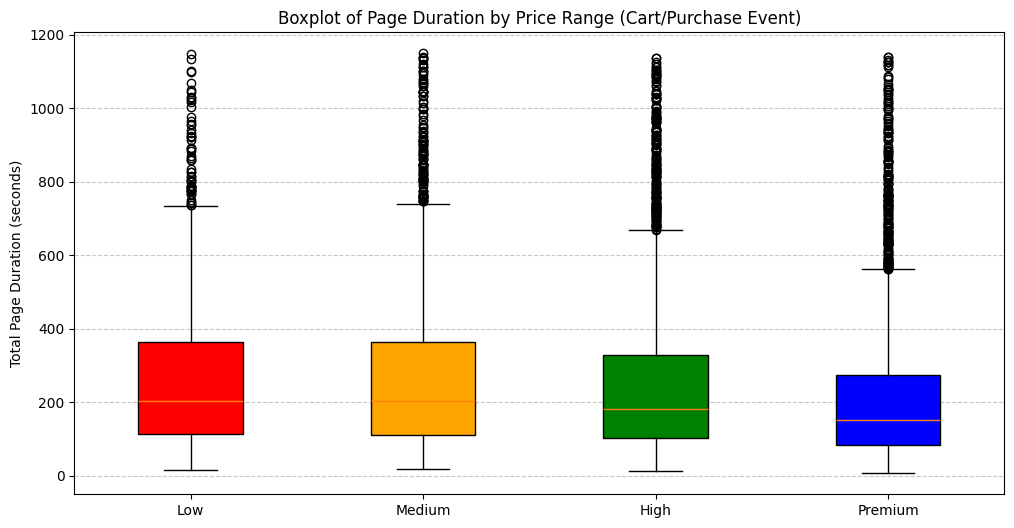

In [ ]:
# Filter 'cart_purchase' event type
filtered_cart_purchase = grouped_data_price[grouped_data_price['event_type_combined'] == 'cart_purchase']

# Filter data by price range
filtered_cart_purchase_by_price = {
    label: filtered_cart_purchase[
        (filtered_cart_purchase['price'] > bounds[0]) & (filtered_cart_purchase['price'] <= bounds[1])
    ]
    for label, bounds in price_ranges.items()
}

# First Plot: Normalized Distribution by Price Range
plt.figure(figsize=(12, 6))
for label, data in filtered_cart_purchase_by_price.items():
    counts, bin_edges = np.histogram(data['time_on_page'], bins=120, range=(0, 600))
    counts = counts / counts.sum() if counts.sum() > 0 else counts
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    plt.plot(bin_centers, counts, label=f'{label} Price', linewidth=2, color=price_colors[label])

plt.title('Normalized Distribution by Price Range (Cart/Purchase Event)')
plt.xlabel('Total Page Duration (seconds)')
plt.ylabel('Relative Distribution')
plt.xticks(np.arange(0, 601, 60))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Second Plot: Boxplot by Price Range (Excluding Outliers)
upper_threshold = np.percentile(filtered_cart_purchase['time_on_page'].dropna(), 95)
filtered_upper_cart_purchase_by_price = {
    label: data[data['time_on_page'] <= upper_threshold] for label, data in filtered_cart_purchase_by_price.items()
}

plt.figure(figsize=(12, 6))
boxplots = plt.boxplot([data['time_on_page'].dropna() for data in filtered_upper_cart_purchase_by_price.values()],
                       tick_labels=filtered_upper_cart_purchase_by_price.keys(), patch_artist=True)

# Apply colors to boxplots
for patch, label in zip(boxplots['boxes'], filtered_upper_cart_purchase_by_price.keys()):
    patch.set_facecolor(price_colors[label])

plt.title('Boxplot of Page Duration by Price Range (Cart/Purchase Event)')
plt.ylabel('Total Page Duration (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


According to the current literature, the distributions of dwell times on various product pages might follow a log-normal distribution. Therefore, a logarithmic transformation is applied to the dwell times, and the new distribution is visualized.

Summary of Log-Transformed Time Durations:
                min   max  mean   std    1%    5%  median   95%   99%
view           0.00  7.25  3.91  1.03  1.79  2.30    3.85  5.70  6.57
cart_purchase  1.95  8.25  5.29  0.93  3.37  3.89    5.23  6.93  7.80


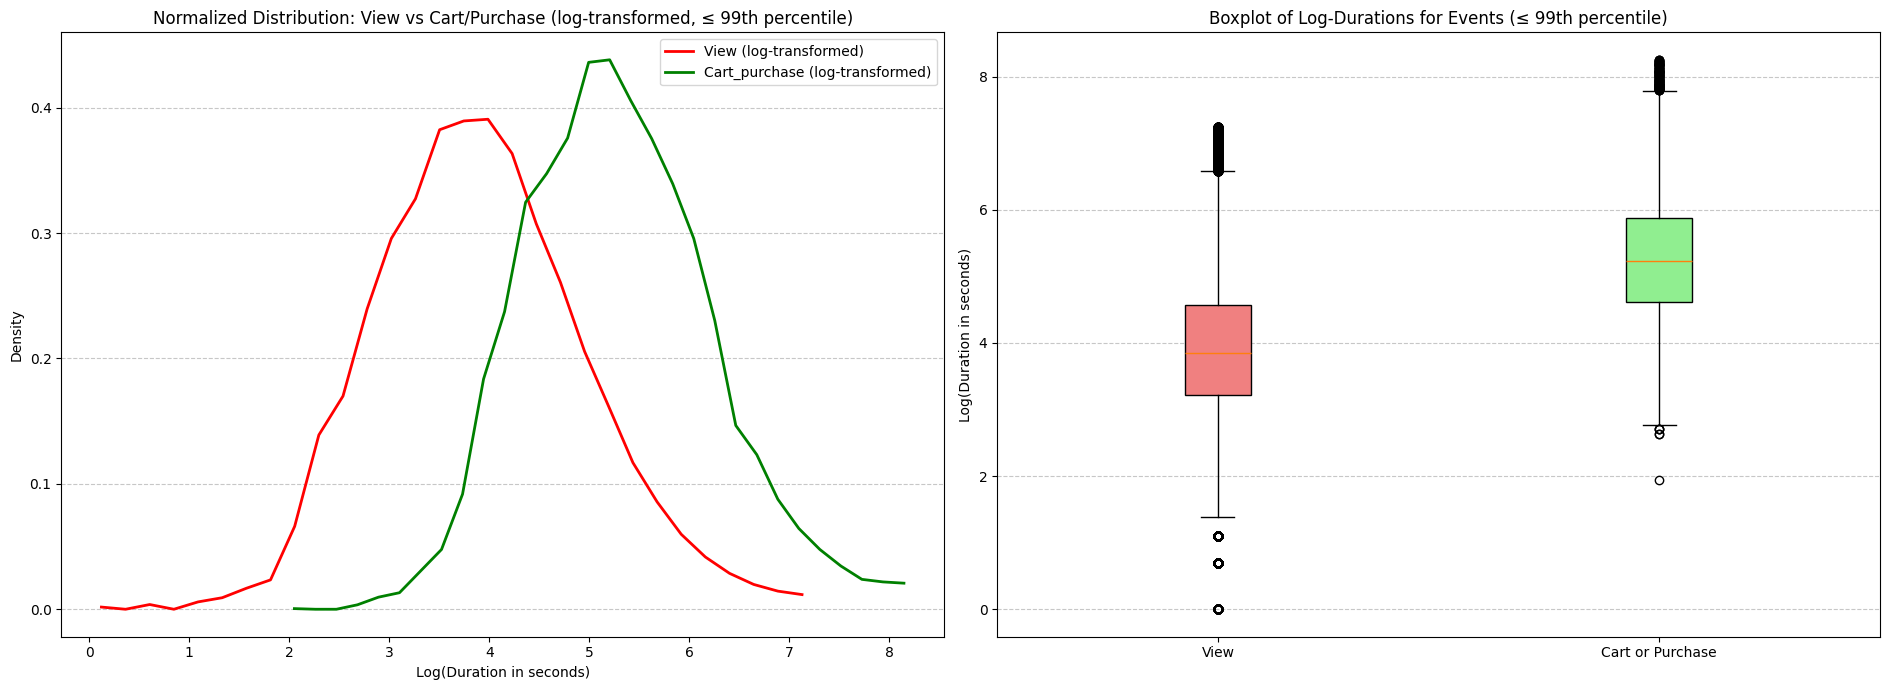

In [ ]:
# Log-transform time_on_page for positive values
log_grouped_data = grouped_data[grouped_data['time_on_page'] > 0].copy()
log_grouped_data['log_time_on_page'] = np.log(log_grouped_data['time_on_page'])

# Filter log-transformed data for 'view' and 'cart_purchase'
log_filtered = {etype: log_grouped_data[log_grouped_data['event_type_combined'] == etype] for etype in ['view', 'cart_purchase']}

# Exclude values beyond the 99th percentile
percentile_99 = {etype: log_filtered[etype]['log_time_on_page'].quantile(0.99) for etype in log_filtered}
log_filtered = {etype: log_filtered[etype][log_filtered[etype]['log_time_on_page'] <= percentile_99[etype]] for etype in log_filtered}

# Function to calculate summary statistics
def calculate_summary(data):
    return {stat: round(func(data), 2) for stat, func in {
        'min': np.min, 'max': np.max, 'mean': np.mean, 'std': np.std,
        '1%': lambda x: np.percentile(x, 1), '5%': lambda x: np.percentile(x, 5),
        'median': np.median, '95%': lambda x: np.percentile(x, 95),
        '99%': lambda x: np.percentile(x, 99)
    }.items()}

# Create summary table
summary_table = pd.DataFrame({etype: calculate_summary(log_filtered[etype]['log_time_on_page']) for etype in log_filtered}).T
print("Summary of Log-Transformed Time Durations:")
print(summary_table)

# Compute histograms and densities
bins = 30
hist_data = {etype: np.histogram(log_filtered[etype]['log_time_on_page'], bins=bins, density=True) for etype in log_filtered}
bin_centers = {etype: 0.5 * (edges[:-1] + edges[1:]) for etype, (_, edges) in hist_data.items()}

# Create plots
plt.figure(figsize=(19, 7))

# First Plot: Normalized Distribution (log-transformed)
plt.subplot(1, 2, 1)
colors = {'view': 'red', 'cart_purchase': 'green'}
for etype in log_filtered:
    plt.plot(bin_centers[etype], hist_data[etype][0], color=colors[etype], linewidth=2, label=f"{etype.capitalize()} (log-transformed)")

plt.title('Normalized Distribution: View vs Cart/Purchase (log-transformed, ≤ 99th percentile)')
plt.xlabel('Log(Duration in seconds)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Second Plot: Boxplot (log-transformed)
plt.subplot(1, 2, 2)
box_data = [log_filtered[etype]['log_time_on_page'] for etype in log_filtered]
box_colors = ['lightcoral', 'lightgreen']
boxplots = plt.boxplot(box_data, tick_labels=['View', 'Cart or Purchase'], patch_artist=True)  # Fixed warning

# Apply colors to boxplots
for patch, color in zip(boxplots['boxes'], box_colors):
    patch.set_facecolor(color)

plt.title('Boxplot of Log-Durations for Events (≤ 99th percentile)')
plt.ylabel('Log(Duration in seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Below, we aim to assess whether a normal distribution provides a good approximation of the previously transformed data. As observed from the graphs, this approximation appears to fit the data well.

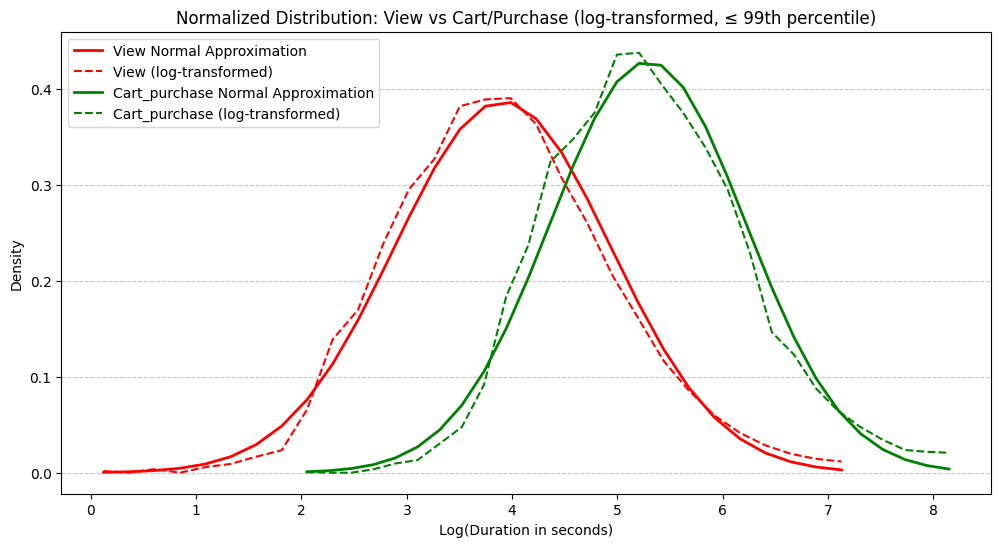

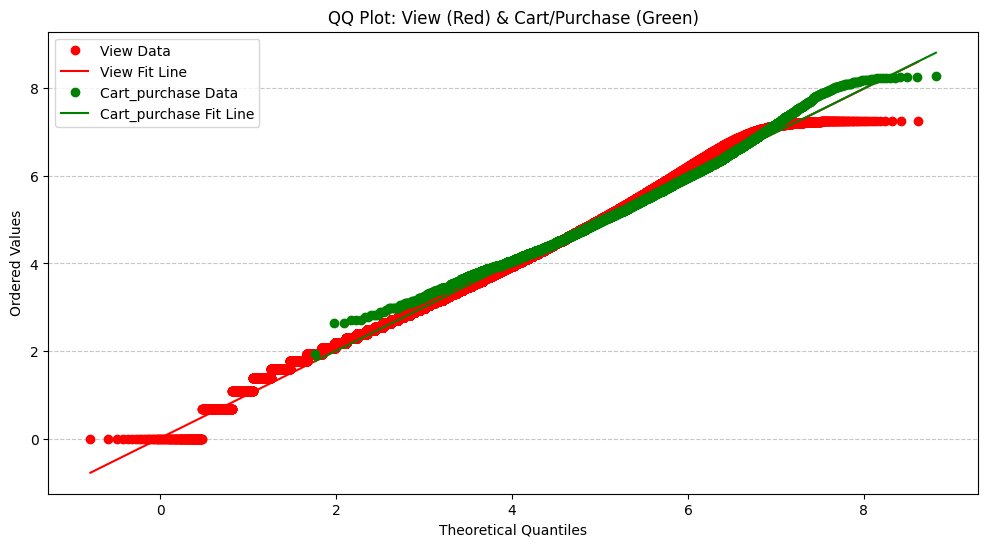

In [ ]:
# Compute histogram distributions (log-transformed)
bins = 30
hist_data = {etype: np.histogram(log_filtered[etype]['log_time_on_page'], bins=bins, density=True) for etype in log_filtered}
bin_centers = {etype: 0.5 * (edges[:-1] + edges[1:]) for etype, (_, edges) in hist_data.items()}

# Fit normal distributions
norm_data = {
    etype: norm.pdf(bin_centers[etype], loc=summary_table.loc[etype, 'mean'], scale=summary_table.loc[etype, 'std'])
    for etype in log_filtered
}

colors = {'view': 'red', 'cart_purchase': 'green'}

# First Plot: Normalized Distribution with Normal Approximations
plt.figure(figsize=(12, 6))
for etype in log_filtered:
    plt.plot(bin_centers[etype], norm_data[etype], color=colors[etype], linestyle='-', linewidth=2, label=f"{etype.capitalize()} Normal Approximation")
    plt.plot(bin_centers[etype], hist_data[etype][0], color=colors[etype], linestyle='--', label=f"{etype.capitalize()} (log-transformed)")

plt.title('Normalized Distribution: View vs Cart/Purchase (log-transformed, ≤ 99th percentile)')
plt.xlabel('Log(Duration in seconds)')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

# Second Plot: QQ Plots
plt.figure(figsize=(12, 6))
for etype in log_filtered:
    stats.probplot(log_filtered[etype]['log_time_on_page'], dist="norm",
                   sparams=(summary_table.loc[etype, 'mean'], summary_table.loc[etype, 'std']), plot=plt)

    # Update QQ plot line colors
    plt.gca().get_lines()[-1].set_color(colors[etype])  # Fit line
    plt.gca().get_lines()[-2].set_color(colors[etype])  # Data points
    plt.gca().get_lines()[-1].set_label(f'{etype.capitalize()} Fit Line')
    plt.gca().get_lines()[-2].set_label(f'{etype.capitalize()} Data')

plt.title('QQ Plot: View (Red) & Cart/Purchase (Green)')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()



The basic idea behind assigning interest scores demonstrated by users on various products primarily revolves around two factors: the type of interaction they had with the product (simply viewing it, adding it to the cart, or purchasing it) and the time spent viewing that product. It makes sense to assign the highest interest score at the product page if the user purchased or added the product to the cart, regardless of the time spent. On the other hand, for viewed products, a high score is assigned if the time spent is deemed to belong to the distribution of times associated with the "cart or purchase" event. If the time spent is significantly low (for example under 5 seconds), it suggests that the user landed on a product page that was vastly different from what they were looking for, which results in a negative interest score.

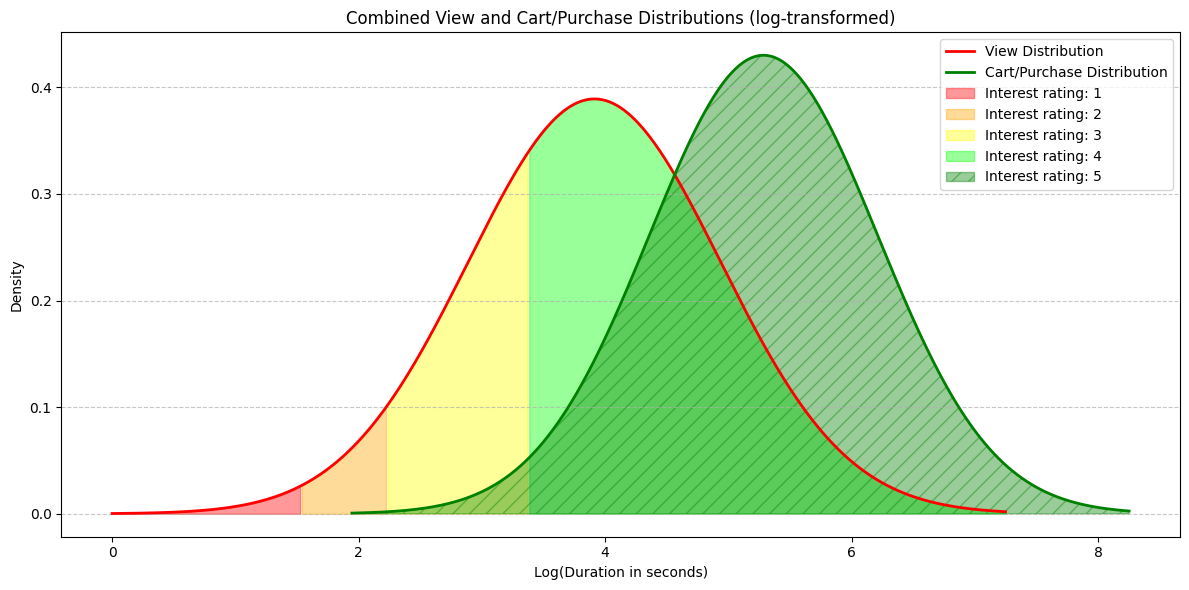

,Interest Showed,Event,Range Time (Log),Range Time (Seconds)
0,1,View,"(0, 1.53)","(0, 4.61)"
1,2,View,"(1.53, 2.23)","(4.61, 9.27)"
2,3,View,"(2.23, 3.38)","(9.27, 29.38)"
3,4,View,"(3.38, ∞)","(29.38, ∞)"
4,5,Cart/Purchase,All,All


In [ ]:
# Fit normal distributions to log-transformed data
view_mean, view_std = norm.fit(log_filtered['view']['log_time_on_page'])
cart_purchase_mean, cart_purchase_std = norm.fit(log_filtered['cart_purchase']['log_time_on_page'])

# Calculate quantiles from fitted normal distributions
quantiles = {
    'view_1%': norm.ppf(0.01, loc=view_mean, scale=view_std),
    'view_5%': norm.ppf(0.05, loc=view_mean, scale=view_std),
    'cart_purchase_2%': norm.ppf(0.02, loc=cart_purchase_mean, scale=cart_purchase_std)
}

# Define interest rating table
interest_table = pd.DataFrame([
    (1, 'View', f"(0, {quantiles['view_1%']:.2f})", f"(0, {np.exp(quantiles['view_1%']):.2f})"),
    (2, 'View', f"({quantiles['view_1%']:.2f}, {quantiles['view_5%']:.2f})",
        f"({np.exp(quantiles['view_1%']):.2f}, {np.exp(quantiles['view_5%']):.2f})"),
    (3, 'View', f"({quantiles['view_5%']:.2f}, {quantiles['cart_purchase_2%']:.2f})",
        f"({np.exp(quantiles['view_5%']):.2f}, {np.exp(quantiles['cart_purchase_2%']):.2f})"),
    (4, 'View', f"({quantiles['cart_purchase_2%']:.2f}, ∞)", f"({np.exp(quantiles['cart_purchase_2%']):.2f}, ∞)"),
    (5, 'Cart/Purchase', "All", "All")
], columns=['Interest Showed', 'Event', 'Range Time (Log)', 'Range Time (Seconds)'])

# ---- Combined Plot: View and Cart/Purchase Distributions ----
plt.figure(figsize=(12, 6))

# Generate smooth bin centers
view_bins = np.linspace(log_filtered['view']['log_time_on_page'].min(), log_filtered['view']['log_time_on_page'].max(), 500)
cart_purchase_bins = np.linspace(log_filtered['cart_purchase']['log_time_on_page'].min(), log_filtered['cart_purchase']['log_time_on_page'].max(), 500)

# Compute normal distributions
view_norm = norm.pdf(view_bins, loc=view_mean, scale=view_std)
cart_purchase_norm = norm.pdf(cart_purchase_bins, loc=cart_purchase_mean, scale=cart_purchase_std)

# Plot distributions
plt.plot(view_bins, view_norm, 'r-', linewidth=2, label='View Distribution')
plt.plot(cart_purchase_bins, cart_purchase_norm, 'g-', linewidth=2, label='Cart/Purchase Distribution')

# Fill View Distribution areas based on interest ratings
fill_areas = [
    (view_bins <= quantiles['view_1%'], 'red', 'Interest rating: 1'),
    ((view_bins > quantiles['view_1%']) & (view_bins <= quantiles['view_5%']), 'orange', 'Interest rating: 2'),
    ((view_bins > quantiles['view_5%']) & (view_bins <= quantiles['cart_purchase_2%']), 'yellow', 'Interest rating: 3'),
    (view_bins > quantiles['cart_purchase_2%'], 'lime', 'Interest rating: 4')
]
for condition, color, label in fill_areas:
    plt.fill_between(view_bins, 0, view_norm, where=condition, color=color, alpha=0.4, label=label)

# Fill Cart/Purchase Distribution with stripes
plt.fill_between(cart_purchase_bins, 0, cart_purchase_norm, color='green', alpha=0.4, hatch='//', label='Interest rating: 5')

plt.title('Combined View and Cart/Purchase Distributions (log-transformed)')
plt.xlabel('Log(Duration in seconds)')
plt.ylabel('Density')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Display the table normally without plotting
interest_table

In [ ]:
# Count how many unique products there are for any category
product_counts_by_category = modified_data.groupby(["category_id","category_code"], dropna=False)["product_id"].nunique().reset_index()
product_counts_by_category.columns = ["category_id", "category_code", "unique_product_count"]

# View the table
product_counts_by_category


,category_id,category_code,unique_product_count
0,2053013552226107603,appliances.environment.fan,10
1,2053013552259662037,NaN,259
2,2053013552293216471,appliances.environment.air_heater,302
3,2053013552326770905,appliances.environment.water_heater,215
4,2053013552351936731,appliances.environment.air_conditioner,136
...,...,...,...
533,2165087460176953468,auto.accessories.compressor,26
534,2172371118332051820,apparel.shoes,5
535,2172371122509578610,apparel.shoes,10
536,2172371436436455782,electronics.tablet,147


Based on the previous considerations, a rating of the interest shown is assigned to each user-product pair. If there is no information on the duration of time spent on the page because it was the last page viewed in a session, a rating of 4 is assigned. This is because there is no evidence to suggest that the time spent on the page was short.

In [ ]:
# Create an explicit copy of the DataFrame to avoid SettingWithCopyWarning
modified_data = modified_data.copy()

# Assign priority to event types
event_priority = {'view': 1, 'cart': 2, 'purchase': 3}
modified_data['event_priority'] = modified_data['event_type'].map(event_priority)

# Initialize the 'Rating' column to handle missing 'time_on_page' values
modified_data.loc[:, 'Rating'] = np.where(modified_data['time_on_page'].isna(), 4, np.nan)
modified_data.loc[:, 'time_on_page'] = modified_data['time_on_page'].fillna(0)  # Fix: Removed inplace=True

# Aggregate data by user, product, and category, selecting the highest-priority event type
grouped_data = (
    modified_data.sort_values('event_priority', ascending=False)
    .groupby(['user_id', 'product_id', 'category_id'], as_index=False)
    .agg(time_on_page=('time_on_page', 'sum'),
         event_type=('event_type', 'first'),
         Rating=('Rating', 'first'))  # Preserve pre-assigned values for missing data
)

# Combine 'cart' and 'purchase' into 'cart_purchase'
grouped_data.loc[:, 'event_type_combined'] = grouped_data['event_type'].replace({'cart': 'cart_purchase', 'purchase': 'cart_purchase'})

# Log-transform 'time_on_page' where > 0
grouped_data = grouped_data[grouped_data['time_on_page'] > 0].copy()
grouped_data.loc[:, 'log_time_on_page'] = np.log(grouped_data['time_on_page'])

# Filter data for 'view' and 'cart_purchase'
filtered = {etype: df for etype, df in grouped_data.groupby('event_type_combined') if etype in ['view', 'cart_purchase']}

# Exclude values beyond the 99th percentile
percentile_99 = {etype: df['log_time_on_page'].quantile(0.99) for etype, df in filtered.items()}
filtered = {etype: df[df['log_time_on_page'] <= percentile_99[etype]] for etype, df in filtered.items()}

# Fit normal distributions and compute quantiles
stats_params = {etype: norm.fit(df['log_time_on_page']) for etype, df in filtered.items()}
quantiles = {
    'view_1%': norm.ppf(0.01, *stats_params['view']),
    'view_5%': norm.ppf(0.05, *stats_params['view']),
    'cart_purchase_2%': norm.ppf(0.02, *stats_params['cart_purchase'])
}

# Function to assign ratings
def assign_rating(row):
    if pd.notnull(row['Rating']):  # Preserve pre-assigned values
        return row['Rating']
    if row['event_type_combined'] == 'cart_purchase':
        return 5
    if row['log_time_on_page'] <= quantiles['view_1%']:
        return 1
    if quantiles['view_1%'] < row['log_time_on_page'] <= quantiles['view_5%']:
        return 2
    if quantiles['view_5%'] < row['log_time_on_page'] <= quantiles['cart_purchase_2%']:
        return 3
    return 4

# Apply rating assignment
grouped_data.loc[:, 'Rating'] = grouped_data.apply(assign_rating, axis=1)

# Final DataFrame with user_id, product_id, and assigned ratings
ratings_user_products = grouped_data[['user_id', 'product_id', 'category_id', 'event_type_combined', 'Rating']]

# Display the resulting DataFrame
ratings_user_products

,user_id,product_id,category_id,event_type_combined,Rating
0,244951053,1003535,2053013555631882655,view,4.0
1,306441847,2501614,2053013564003713919,view,4.0
2,315805600,3600591,2053013563810775923,view,4.0
3,315805600,3600592,2053013563810775923,view,3.0
4,315805600,3601138,2053013563810775923,view,3.0
...,...,...,...,...,...
295568,555615559,1004858,2053013555631882655,view,4.0
295569,555615629,1004659,2053013555631882655,view,4.0
295570,555615755,4804056,2053013554658804075,view,2.0
295571,555615808,1700781,2053013553031414015,view,3.0


# Content-based mixed with Collaborative Filtering approach

The recommendation system should be built based on product similarity, following the logic that if a user lands on a product page, similar products are suggested. This approach aims to provide more options to the user and encourage them to spend more time on the site.

It is highly likely that similar products belong to the same cluster, and in this case, the product categories already defined in the dataset can be leveraged. However, it is necessary to first verify that these categories are well-defined and distinct. There might be small differences between some categories, and within the same session, users might frequently search for products from different categories recurrently.

To assess this, a similarity-checking algorithm between categories is developed.

In [ ]:
# Exclude users who have viewed only one product's page
filtered_users = modified_data['user_id'].value_counts()[lambda x: x > 1].index
filtered_data = modified_data[modified_data['user_id'].isin(filtered_users)]

# Group by user_session and category_id
grouped_categories_ratings = (
    filtered_data.sort_values('event_priority', ascending=False)
    .groupby(['user_session', 'category_id'])
    .agg(time_on_page=('time_on_page', 'sum'),
         event_type=('event_type', 'first'),
         Rating=('Rating', 'first'))  # Preserve pre-assigned Rating for NA cases
    .reset_index()
)

# Combine 'cart' and 'purchase' into 'cart_purchase'
grouped_categories_ratings['event_type_combined'] = grouped_categories_ratings['event_type'].replace({'cart': 'cart_purchase', 'purchase': 'cart_purchase'})

# Log-transform time_on_page where > 0
grouped_categories_ratings = grouped_categories_ratings[grouped_categories_ratings['time_on_page'] > 0].copy()
grouped_categories_ratings['log_time_on_page'] = np.log(grouped_categories_ratings['time_on_page'])

# Filter data for 'view' and 'cart_purchase'
filtered = {etype: grouped_categories_ratings[grouped_categories_ratings['event_type_combined'] == etype] for etype in ['view', 'cart_purchase']}

# Exclude values beyond the 99th percentile
percentile_99 = {etype: filtered[etype]['log_time_on_page'].quantile(0.99) for etype in filtered}
filtered = {etype: filtered[etype][filtered[etype]['log_time_on_page'] <= percentile_99[etype]] for etype in filtered}

# Fit normal distributions and compute quantiles
stats_params = {etype: norm.fit(filtered[etype]['log_time_on_page']) for etype in filtered}
quantiles = {
    'view_1%': norm.ppf(0.01, *stats_params['view']),
    'view_5%': norm.ppf(0.05, *stats_params['view']),
    'cart_purchase_1%': norm.ppf(0.01, *stats_params['cart_purchase'])
}

# Function to assign ratings
def assign_rating(row):
    if row['log_time_on_page'] <= quantiles['view_1%']:
        return 1
    if row['log_time_on_page'] <= quantiles['view_5%']:
        return 2
    return 3

# Apply rating assignment
grouped_categories_ratings['Rating'] = grouped_categories_ratings.apply(assign_rating, axis=1)

# Assign final interest score based on rating conditions
grouped_categories_ratings['Interest'] = (grouped_categories_ratings['Rating'] >= 3).astype(int)

# Ensure if a session has both 0 and 1 interest values, it gets assigned 1
interest_data_by_category = grouped_categories_ratings.groupby(['user_session', 'category_id'])['Interest'].max().reset_index()

# Count the number of unique categories per session
category_count_per_session = (
    interest_data_by_category.groupby('user_session')['category_id']
    .nunique()
    .value_counts()
    .reset_index(name='Count')
    .rename(columns={'index': 'Number_of_Categories'})
)

# Display the resulting DataFrame
category_count_per_session


,category_id,Count
0,1,55687
1,2,11034
2,3,3598
3,4,1567
4,5,784
5,6,438
6,7,272
7,8,171
8,9,95
9,10,60



# Jaccard Similarity using MinHashing between Categories

As expected, most of the times, users within the same session tend to search for products belonging to the same category.

To measure the similarity between categories, we analyze how often users search for products from both categories within the same session. Two categories are considered similar if users frequently browse products from both in a single session.

To compute this similarity, we use Jaccard Similarity, which measures the overlap between sets. Since directly computing Jaccard similarity can be computationally expensive for large datasets, we implement MinHashing, a probabilistic algorithm that efficiently approximates Jaccard similarity.

After assigning a binary value to the category rating given by the user during the session, the session IDs are replaced with sequential numbers. This transformation allows the creation of a utility matrix, where session IDs serve as row indices and category IDs are used as column indices.

In [ ]:
# Map unique user_session IDs to progressive numbers
session_mapping = {session_id: idx for idx, session_id in enumerate(interest_data_by_category['user_session'].unique())}

# Replace user_session IDs with progressive numbers
interest_data_by_category['user_session'] = interest_data_by_category['user_session'].map(session_mapping)

# Display the updated table
interest_data_by_category


,user_session,category_id,Interest
0,0,2053013554658804075,1
1,0,2053013555631882655,1
2,0,2053013561185141473,1
3,1,2053013552913973497,1
4,2,2053013563584283495,1
...,...,...,...
107513,73805,2053013563173241677,1
107514,73806,2053013565480109009,1
107515,73806,2053013565748544479,1
107516,73807,2053013561847841545,1


Next, 200 row permutations are generated by applying a hash function to the previously modified session IDs. This process ensures a randomized yet consistent transformation of the data.

In [ ]:
import random
from math import gcd

# Set a fixed seed for reproducibility
random.seed(42)

# Number of distinct user_session IDs
n = len(session_mapping)

# Copy interest_data_by_category for permutation
permutation_interest_data_by_category = interest_data_by_category.copy()

# Generate 200 valid (a, b) pairs where gcd(a, n) = 1
valid_pairs = []
while len(valid_pairs) < 200:
    a = random.randint(1, n - 1)  # Random a in [1, n-1]
    b = random.randint(0, n - 1)  # Random b in [0, n-1]
    if gcd(a, n) == 1:
        valid_pairs.append((a, b))

# Compute new column values efficiently
new_columns_df = pd.DataFrame({
    f"({a}, {b})": (a * permutation_interest_data_by_category['user_session'] + b) % n
    for a, b in valid_pairs
})

# Concatenate all new columns at once
permutation_interest_data_by_category = pd.concat([permutation_interest_data_by_category, new_columns_df], axis=1)

# Display the updated DataFrame
permutation_interest_data_by_category


,user_session,category_id,Interest,"(14593, 3278)","(36049, 32098)","(29257, 18289)","(13435, 71482)","(12281, 28657)","(26063, 71426)","(58879, 36463)",...,"(9151, 36208)","(66551, 35018)","(337, 37072)","(39133, 64178)","(19477, 58529)","(70593, 63483)","(45237, 43573)","(72341, 71228)","(42177, 24727)","(31301, 50196)"
0,0,2053013554658804075,1,3278,32098,18289,71482,28657,71426,36463,...,36208,35018,37072,64178,58529,63483,43573,71228,24727,50196
1,0,2053013555631882655,1,3278,32098,18289,71482,28657,71426,36463,...,36208,35018,37072,64178,58529,63483,43573,71228,24727,50196
2,0,2053013561185141473,1,3278,32098,18289,71482,28657,71426,36463,...,36208,35018,37072,64178,58529,63483,43573,71228,24727,50196
3,1,2053013552913973497,1,17871,68147,47546,11109,40938,23681,21534,...,45359,27761,37409,29503,4198,60268,15002,69761,66904,7689
4,2,2053013563584283495,1,32464,30388,2995,24544,53219,49744,6605,...,54510,20504,37746,68636,23675,57053,60239,68294,35273,38990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107513,73805,2053013563173241677,1,33307,71567,4326,31177,65622,67045,7442,...,8755,56789,36061,20587,98,73128,55478,1821,45812,30101
107514,73806,2053013565480109009,1,47900,33808,33583,44612,4095,19300,66321,...,17906,49532,36398,59720,19575,69913,26907,354,14181,61402
107515,73806,2053013565748544479,1,47900,33808,33583,44612,4095,19300,66321,...,17906,49532,36398,59720,19575,69913,26907,354,14181,61402
107516,73807,2053013561847841545,1,62493,69857,62840,58047,16376,45363,51392,...,27057,42275,36735,25045,39052,66698,72144,72695,56358,18895



After performing the permutations, for each category and each permutation of the utility matrix, the first row in the permuted matrix containing a 1 for the given category is identified. This captures a compact signature representing the category's presence across sessions.

In [ ]:
# Create DataFrame with unique category IDs
signatures_category_by_session = pd.DataFrame({'category_id': permutation_interest_data_by_category['category_id'].unique()})

# Compute the minimum value for each category across all permutation columns
min_values_df = permutation_interest_data_by_category.groupby('category_id')[new_columns_df.columns].min().reset_index()

# Merge min values into the signature table
signatures_category_by_session = signatures_category_by_session.merge(min_values_df, on='category_id', how='left')

# Display the resulting table
signatures_category_by_session


,category_id,"(14593, 3278)","(36049, 32098)","(29257, 18289)","(13435, 71482)","(12281, 28657)","(26063, 71426)","(58879, 36463)","(55393, 44597)","(13397, 12156)",...,"(9151, 36208)","(66551, 35018)","(337, 37072)","(39133, 64178)","(19477, 58529)","(70593, 63483)","(45237, 43573)","(72341, 71228)","(42177, 24727)","(31301, 50196)"
0,2053013554658804075,22,38,5,24,0,32,45,25,77,...,88,5,10,88,17,143,21,3,30,42
1,2053013555631882655,0,4,3,4,4,2,2,2,3,...,1,2,6,0,10,1,5,0,5,0
2,2053013561185141473,46,230,210,1661,1605,434,5,768,70,...,1353,1911,404,137,240,349,3491,665,245,1050
3,2053013552913973497,624,562,557,0,35,488,734,58,163,...,250,81,2,48,395,503,61,8,229,354
4,2053013563584283495,50,80,63,106,21,75,76,64,56,...,42,140,20,70,21,71,36,72,119,170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,2053013557787755041,37742,28483,209,11736,5409,30769,1182,3413,17404,...,50214,29585,10657,1460,8579,10396,231,929,12215,27801
534,2053013559222207091,70619,20447,52118,49753,46278,44293,31618,51554,62077,...,54771,42437,25133,14011,10882,47944,2086,7341,54196,17525
535,2134904816839688395,57574,39002,31609,57954,35497,2458,28647,11581,46500,...,43288,11522,49544,16138,35577,71747,24541,17812,73135,32940
536,2075962341706433246,22008,40140,64059,58632,12763,27160,56373,31775,60350,...,17814,21440,60922,4884,8531,63509,57303,67934,55585,63878


All category pairs are now compared to generate a similarity matrix. Similarity is measured as the percentage of matching MinHash signatures across all permutations, providing an efficient approximation of Jaccard Similarity.

In [ ]:
# Extract category IDs and permutation columns as NumPy arrays
category_ids = signatures_category_by_session['category_id'].to_numpy()
columns_data = signatures_category_by_session.iloc[:, 1:].to_numpy()

# Compute similarity matrix using broadcasting
similarity_matrix = np.round(np.equal(columns_data[:, None, :], columns_data[None, :, :]).mean(axis=2), 2)

# Convert to DataFrame for visualization
similarity_matrix_df = pd.DataFrame(similarity_matrix, index=category_ids, columns=category_ids)

# Display the resulting similarity matrix
similarity_matrix_df


,2053013554658804075,2053013555631882655,2053013561185141473,2053013552913973497,2053013563584283495,2053013563651392361,2053013563693335403,2053013555816432043,2053013562611204913,2053013562837697343,...,2110937219442148235,2141355031935321056,2146660886926852416,2053013561529074421,2134904835026190593,2053013557787755041,2053013559222207091,2134904816839688395,2075962341706433246,2053013559138321009
2053013554658804075,1.0,0.0,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2053013555631882655,0.0,1.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2053013561185141473,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2053013552913973497,0.0,0.0,0.0,1.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
2053013563584283495,0.0,0.0,0.0,0.0,1.0,0.15,0.10,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2053013557787755041,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0
2053013559222207091,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.52,0.0,1.0,0.0,0.0,0.0
2134904816839688395,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0
2075962341706433246,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,1.0,0.0


The following table shows the product categories with the greatest similarities. Users who frequently searched for products in one category also showed interest in those belonging to the other.

It is worth noting that some category names are repeated multiple times with different ID codes, further emphasizing the need to determine the similarity between various product categories.

Similarities between products should therefore be identified either within the same product category or within a similar one, referring to this table.

In [ ]:
# Choose the threshold for determine similarity between categories
threshold = 0.03

# Extract upper triangle of similarity matrix (excluding diagonal)
category_ids = signatures_category_by_session['category_id'].values
similar_pairs = np.argwhere(np.triu(similarity_matrix, k=1) >= threshold)

# Create DataFrame with similar category pairs
similar_pairs_df = pd.DataFrame(
    [(category_ids[i], category_ids[j], similarity_matrix[i, j]) for i, j in similar_pairs],
    columns=['Category_1', 'Category_2', 'Similarity']
)

# Determine most representative brand per category
representative_brands = modified_data.groupby('category_id')['brand'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Create mapping for category_code and brand
id_to_category_mapping = modified_data[['category_id', 'category_code']].drop_duplicates().set_index('category_id')['category_code']
id_to_brand_mapping = representative_brands

# Map category names and brands
similar_pairs_df['Category_1_Code'] = similar_pairs_df['Category_1'].map(id_to_category_mapping)
similar_pairs_df['Category_1_Brand'] = similar_pairs_df['Category_1'].map(id_to_brand_mapping)
similar_pairs_df['Category_2_Code'] = similar_pairs_df['Category_2'].map(id_to_category_mapping)
similar_pairs_df['Category_2_Brand'] = similar_pairs_df['Category_2'].map(id_to_brand_mapping)

# Sort by similarity in descending order
similar_pairs_df = similar_pairs_df.sort_values(by='Similarity', ascending=False)

# Reorder columns for clarity
similar_pairs_df = similar_pairs_df[['Category_1', 'Category_1_Code', 'Category_1_Brand',
                                     'Category_2', 'Category_2_Code', 'Category_2_Brand', 'Similarity']]

# Display the final DataFrame
similar_pairs_df

,Category_1,Category_1_Code,Category_1_Brand,Category_2,Category_2_Code,Category_2_Brand,Similarity
1808,2134904835026190593,NaN,nika,2053013559222207091,NaN,None,0.52
1806,2172371118332051820,apparel.shoes,burton,2053013559222207091,NaN,None,0.36
987,2076715364204413467,NaN,carters,2078957461921858354,NaN,carters,0.34
1797,2053013555657048481,NaN,stiga,2053013559138321009,NaN,anon,0.31
241,2053013566587404305,NaN,shimano,2055156924466332447,NaN,shimano,0.30
...,...,...,...,...,...,...,...
1311,2070005009172398851,NaN,boyscout,2086471239416676686,NaN,coleman,0.03
1308,2070005009172398851,NaN,boyscout,2098563460336976001,construction.tools.pump,bestway,0.03
1307,2070005009172398851,NaN,boyscout,2055156924407612189,accessories.bag,plano,0.03
1303,2069241409453425602,appliances.kitchen.grill,obi,2053013561352913645,NaN,bestway,0.03


# First approach using Cosine Similarity

Product similarity is now determined by comparing product pairs using Cosine Similarity. Before applying it, the interest ratings for each product must be centered to ensure meaningful comparisons. The centering process follows these rules:

(1) → (-1): A negative score indicates immediate disinterest, as the user left the page in less than 5 seconds, realizing the product was completely irrelevant.

(2) → (0): A neutral score means the product was somewhat relevant but ultimately not of interest. This score also applies to products the user never viewed.

(3) → (1): A positive score suggests mild interest, as the user spent at least 10 seconds on the page, indicating alignment with their search.

(4) → (2): A high interest score, with the user staying for around 25 seconds—comparable to the time spent on products they later purchase.

(5) → (3): The highest level of interest, as the user either added the product to the cart or purchased it.

Most values are positive, which aligns with user behavior, since users tend to open pages that already seem relevant based on product thumbnails.

In [ ]:
# Filter users who have rated more than one product
filtered_ratings_user_products = ratings_user_products.groupby('user_id').filter(lambda x: len(x) >= 2)

# Filter products that appear at least 3 times
filtered_ratings_user_products = filtered_ratings_user_products.groupby('product_id').filter(lambda x: len(x) >= 3)

# Adjust ratings by reducing them by 2
filtered_ratings_user_products['Rating'] = filtered_ratings_user_products['Rating'] - 2

# Replace user_id with progressive numbering
filtered_ratings_user_products['user_id'] = filtered_ratings_user_products['user_id'].astype('category').cat.codes + 1

# Display the final DataFrame
filtered_ratings_user_products


,user_id,product_id,category_id,event_type_combined,Rating
2,1,3600591,2053013563810775923,view,2.0
3,1,3600592,2053013563810775923,view,1.0
4,1,3601138,2053013563810775923,view,1.0
7,2,3700006,2053013565983425517,view,2.0
8,2,3700298,2053013565983425517,view,2.0
...,...,...,...,...,...
295550,46638,1005100,2053013555631882655,view,1.0
295553,46639,1003306,2053013555631882655,view,1.0
295554,46639,1003363,2053013555631882655,view,1.0
295571,46640,1700781,2053013553031414015,view,1.0


Product comparisons are now limited to candidates identified in previous analyses.

In the first phase, all product pairs within the same category are compared to assess their similarity.

In [ ]:
import time
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Create rating matrix for each category
def create_rating_matrix(df):
    unique_users = df['user_id'].unique()
    unique_products = df['product_id'].unique()

    # Create index mappings for users and products
    user_index = {user_id: idx for idx, user_id in enumerate(unique_users)}
    product_index = {product_id: idx for idx, product_id in enumerate(unique_products)}

    # Initialize an empty rating matrix (products × users)
    rating_matrix = np.zeros((len(unique_products), len(unique_users)))

    # Populate the matrix with ratings
    for _, row in df.iterrows():
        rating_matrix[product_index[row['product_id']], user_index[row['user_id']]] = row['Rating']

    return rating_matrix, unique_products

# Lists to store results
similarity_results = []
duration_comparisons_combinations_Algorithm_1 = []
categories = filtered_ratings_user_products['category_id'].unique()

# Progress bar for category processing
with tqdm(total=len(categories), desc="Processing Categories", unit="cat") as pbar:
    for category in categories:
        start_time = time.time()  # Start timing the entire process

        category_df = filtered_ratings_user_products[filtered_ratings_user_products['category_id'] == category]

        # Skip categories with fewer than 2 unique products
        if category_df['product_id'].nunique() < 2:
            pbar.update(1)
            continue

        # Generate the rating matrix
        rating_matrix, product_ids = create_rating_matrix(category_df)

        # Compute cosine similarity
        similarity_matrix = cosine_similarity(rating_matrix)

        # Extract upper triangle (excluding diagonal)
        indices = np.triu_indices(len(product_ids), k=1)
        similar_items = [
            (product_ids[i], product_ids[j], similarity_matrix[i, j])
            for i, j in zip(indices[0], indices[1]) if similarity_matrix[i, j] > 0
        ]

        # Store similarity results
        similarity_results.extend(similar_items)

        # End timer
        end_time = time.time()
        duration = end_time - start_time

        # Store duration and number of comparisons
        num_comparisons = len(indices[0])
        duration_comparisons_combinations_Algorithm_1.append((num_comparisons, duration))

        pbar.update(1)  # Update progress bar

# Create DataFrame
products_similarity_same_category = pd.DataFrame(similarity_results, columns=['Product_1', 'Product_2', 'Cosine_Similarity'])

# Display final similarity DataFrame
products_similarity_same_category

Processing Categories: 100%|██████████| 481/481 [00:19<00:00, 24.70cat/s] 


,Product_1,Product_2,Cosine_Similarity
0,3600591,3600592,0.141895
1,3600591,3601138,0.218949
2,3600591,3601311,0.050564
3,3600591,3600163,0.018069
4,3600591,3601405,0.025959
...,...,...,...
271934,19000249,19001058,0.192450
271935,19000249,19001767,0.111111
271936,19001058,19001767,0.192450
271937,28704796,28713990,0.192450


In the second phase, all product pairs from two different but previously identified similar categories are compared.

In [ ]:
# Efficiently create a unified rating matrix for two categories
def create_combined_rating_matrix(df1, df2):
    unified_users = np.union1d(df1['user_id'].unique(), df2['user_id'].unique())
    user_index = {user_id: idx for idx, user_id in enumerate(unified_users)}

    # Extract unique product IDs
    products_1, products_2 = df1['product_id'].unique(), df2['product_id'].unique()

    # Initialize rating matrices
    rating_matrix_1 = np.zeros((len(products_1), len(unified_users)))
    rating_matrix_2 = np.zeros((len(products_2), len(unified_users)))

    # Populate rating matrices
    for df, matrix, products in [(df1, rating_matrix_1, products_1), (df2, rating_matrix_2, products_2)]:
        for _, row in df.iterrows():
            matrix[np.where(products == row['product_id'])[0][0], user_index[row['user_id']]] = row['Rating']

    return rating_matrix_1, rating_matrix_2, products_1, products_2

# Initialize results lists
similarity_results_2 = []

# Process category pairs with a progress bar
with tqdm(total=len(similar_pairs_df), desc="Processing Category Pairs", unit="pairs") as pbar:
    for _, row in similar_pairs_df.iterrows():
        start_time = time.time()  # Start timing the entire process

        category_1, category_2 = row['Category_1'], row['Category_2']

        # Filter data for the two categories
        df1 = filtered_ratings_user_products.loc[filtered_ratings_user_products['category_id'] == category_1]
        df2 = filtered_ratings_user_products.loc[filtered_ratings_user_products['category_id'] == category_2]

        # Skip computation if either category has fewer than 2 products
        if df1['product_id'].nunique() < 2 or df2['product_id'].nunique() < 2:
            pbar.update(1)
            continue

        # Generate rating matrices
        matrix_1, matrix_2, products_1, products_2 = create_combined_rating_matrix(df1, df2)

        # Compute cosine similarity between the two categories
        similarity_matrix = cosine_similarity(matrix_1, matrix_2)

        # Extract product pairs with similarity > 0 (efficiently)
        if np.any(similarity_matrix > 0):
            similar_items = [
                (products_1[i], products_2[j], similarity_matrix[i, j])
                for i, j in zip(*np.where(similarity_matrix > 0))
            ]
            similarity_results_2.extend(similar_items)

        # End timing
        end_time = time.time()
        duration = end_time - start_time

        # Store duration and number of comparisons
        num_comparisons = len(products_1) * len(products_2)
        duration_comparisons_combinations_Algorithm_1.append((num_comparisons, duration))

        pbar.update(1)  # Update progress bar


# Create results DataFrames
products_similarity_different_categories = pd.DataFrame(similarity_results_2, columns=['Product_1', 'Product_2', 'Cosine_Similarity'])
duration_comparisons_combinations_Algorithm_1 = pd.DataFrame(duration_comparisons_combinations_Algorithm_1, columns=['Total_Comparisons', 'Duration'])

# Display final similarity DataFrame
products_similarity_different_categories

Processing Category Pairs: 100%|██████████| 1809/1809 [01:21<00:00, 22.32pairs/s]


,Product_1,Product_2,Cosine_Similarity
0,37500560,37800028,0.077411
1,37500560,37800036,0.210819
2,37500678,37800028,0.070667
3,37500237,37800028,0.167600
4,37500237,37800027,0.134164
...,...,...,...
102211,35000000,43000002,0.059470
102212,35000000,32900026,0.067806
102213,35000000,32900067,0.041851
102214,35000000,32900127,0.056802



The results from both phases are then combined into a single table, forming the final similarity matrix.

In [ ]:
# Concatenate both tables and remove duplicates in a single operation
products_similarity_after_grouping = pd.concat([products_similarity_same_category, products_similarity_different_categories], ignore_index=True).drop_duplicates()

# Rename 'Cosine_Similarity' to 'Similarity'
products_similarity_after_grouping = products_similarity_after_grouping.rename(columns={'Cosine_Similarity': 'Similarity'})

# Sort the results by Similarity in descending order
products_similarity_after_grouping = products_similarity_after_grouping.sort_values(by='Similarity', ascending=False)

# Display the final DataFrame
products_similarity_after_grouping


,Product_1,Product_2,Similarity
265556,8700293,8700440,1.000000e+00
268717,14300244,14300246,9.701425e-01
207216,7900243,7900277,9.622504e-01
249771,19100103,19100351,9.622504e-01
201862,2400243,2400578,9.622504e-01
...,...,...,...
270871,28900017,28900020,3.722196e-19
232785,43900026,43900028,2.449416e-19
128358,21400813,21408696,9.185848e-20
358911,23300385,16400204,8.050352e-20


Below, you can check the top twenty recommended products for a given item after entering its product_id as input.

In [ ]:
# Load product details dataset
csv_url = "https://docs.google.com/spreadsheets/d/17XuSdif-t4LdWs2JHn6wnIraMurkpcIxXkjvhMnUWko/export?format=csv&gid=665062436"
product_details_df = pd.read_csv(csv_url).rename(columns=str.strip)

# Get product_id input
try:
    product_id = int(input("Enter product_id: "))
except ValueError:
    exit("Invalid input: product_id must be an integer.")

# Retrieve product details
selected_product = product_details_df.query("product_id == @product_id")
if selected_product.empty:
    exit("Error: product_id not found in the dataset.")

print("\nSelected Product Details:")
print(selected_product[['product_id', 'category_code', 'brand', 'price', 'product_code']].to_string(index=False))

# Get top 20 most similar products
associated_products = products_similarity_after_grouping.query("Product_1 == @product_id or Product_2 == @product_id")
associated_products = associated_products.copy()
associated_products.loc[:, "Product_2"] = np.where(associated_products["Product_1"] == product_id, associated_products["Product_2"], associated_products["Product_1"])
recommended_products = associated_products.nlargest(20, "Similarity")[["Product_2", "Similarity"]]

# Merge with product details and calculate average price
recommended_products = recommended_products.merge(product_details_df, left_on="Product_2", right_on="product_id", how="left")
recommended_products["price"] = recommended_products["price"].astype(str).str.replace(',', '.').astype(float)
recommended_products = recommended_products.groupby(["product_id", "category_code", "brand", "product_code"], dropna=False, as_index=False).agg({"price": "mean", "Similarity": "max"})

# Round price and sort by similarity
recommended_products["price"] = recommended_products["price"].round(2)
recommended_products_top20 = recommended_products.nlargest(20, "Similarity")

# Display recommendations
recommended_products_top20


Enter product_id: 1005135

Selected Product Details:
 product_id          category_code brand   price       product_code
    1005135 electronics.smartphone apple 1747,79 smartphone_generic


,product_id,category_code,brand,product_code,price,Similarity
4,1005105,electronics.smartphone,apple,smartphone_generic,1415.48,0.166121
10,1005124,electronics.smartphone,apple,smartphone_generic,1634.51,0.146821
6,1005115,electronics.smartphone,apple,smartphone_high_end,975.56,0.135827
19,1005144,electronics.smartphone,apple,smartphone_generic,1747.79,0.112431
14,1005133,electronics.smartphone,apple,smartphone_generic,1619.09,0.095332
12,1005130,electronics.smartphone,apple,smartphone_generic,1619.09,0.094374
15,1005136,electronics.smartphone,apple,smartphone_generic,2056.68,0.092667
13,1005132,electronics.smartphone,apple,smartphone_generic,1413.16,0.090758
16,1005138,electronics.smartphone,apple,smartphone_generic,1747.79,0.090626
17,1005141,electronics.smartphone,apple,smartphone_generic,1746.89,0.085735



# Second approach using SimHash and LSH with random hyperplanes

Another scalable approach to finding similar products is to use Locality-Sensitive Hashing (LSH) with randomly generated hyperplanes. This method allows for efficient similarity comparisons by transforming high-dimensional product vectors into significantly shorter binary signatures. Instead of directly comparing large vectors, we compute the Hamming distance between these compact signatures, drastically reducing computational complexity while preserving similarity relationships. This approach is particularly effective for handling large datasets, as it enables fast and approximate nearest-neighbor searches.

The process begins by generating random hyperplanes, which serve as decision boundaries in a high-dimensional space. Each product's interaction vector is then projected onto these hyperplanes, and for each projection, a binary value (0 or 1) is assigned to its signature, depending on whether the projection falls below or above the hyperplane. This transformation compresses the original high-dimensional data into compact binary signatures, allowing for efficient similarity comparisons using Hamming distance.

In [ ]:
# Define parameters
num_users = filtered_ratings_user_products['user_id'].nunique()
k = 200  # Number of hyperplanes

# Generate k random hyperplane vectors
random_vectors = np.random.rand(k, num_users) - 0.5

# Initialize list for DataFrame
rows = []

# Compute product signatures efficiently
for (product, category), group in filtered_ratings_user_products.groupby(['product_id', 'category_id']):
    user_indices = group['user_id'].values - 1  # Convert to zero-based index
    ratings_vector = np.zeros(num_users)
    ratings_vector[user_indices] = group['Rating'].values
    signature = (np.dot(random_vectors, ratings_vector) >= 0).astype(int)

    # Append to list
    for i in range(k):
        rows.append((product, category, f'hyperplane_{i+1}', signature[i]))

# Create DataFrame
hyperplanes_signatures = pd.DataFrame(rows, columns=['product_id', 'category_id', 'Random hyperplane', 'Signature'])

# Display the DataFrame
hyperplanes_signatures

,product_id,category_id,Random hyperplane,Signature
0,1001588,2053013555631882655,hyperplane_1,1
1,1001588,2053013555631882655,hyperplane_2,1
2,1001588,2053013555631882655,hyperplane_3,1
3,1001588,2053013555631882655,hyperplane_4,0
4,1001588,2053013555631882655,hyperplane_5,0
...,...,...,...,...
3383395,53900012,2144916515806248980,hyperplane_196,1
3383396,53900012,2144916515806248980,hyperplane_197,1
3383397,53900012,2144916515806248980,hyperplane_198,1
3383398,53900012,2144916515806248980,hyperplane_199,1


As done previously, pairs of products are compared by means of two loops. The first within individual categories, the second within pairs of similar categories.

In [ ]:
from sklearn.metrics import pairwise_distances

# Create a pivot table
signature_pivot = hyperplanes_signatures.pivot_table(
    index='product_id',
    columns='Random hyperplane',
    values='Signature',
    aggfunc='first'
).fillna(0)

# Map categories to products
category_to_products = hyperplanes_signatures.groupby('category_id')['product_id'].unique().to_dict()
categories = list(category_to_products.keys())

def hamming_similarity_matrix(matrix):
    distances = pairwise_distances(matrix, metric='hamming')
    return 1 - distances

# Similarities within the same category
similarity_results_same_cat = []
duration_comparisons_combinations_Algorithm_2 = []  # <- Use Algorithm_2 for storing durations

for cat in tqdm(categories, desc="Processing Categories", unit="cat"):
    start_time = time.time()
    product_ids = category_to_products[cat]

    if len(product_ids) < 2:
        continue

    valid_products = list(set(product_ids) & set(signature_pivot.index))
    if len(valid_products) < 2:
        continue

    matrix_cat = signature_pivot.loc[valid_products].values
    similarity_matrix = hamming_similarity_matrix(matrix_cat)

    # Get the upper triangular indices (excluding the diagonal)
    indices = np.triu_indices(len(valid_products), k=1)
    for i, j in zip(*indices):
        sim_val = similarity_matrix[i, j]
        if sim_val > 0:
            similarity_results_same_cat.append((valid_products[i], valid_products[j], sim_val))

    duration = time.time() - start_time
    # Number of comparisons is the count of pairs in indices
    duration_comparisons_combinations_Algorithm_2.append((len(indices[0]), duration))

# Similarities between pairs of categories
similarity_results_different_cat = []

for _, row in tqdm(similar_pairs_df.iterrows(), total=len(similar_pairs_df),
                   desc="Processing Category Pairs", unit="pairs"):
    start_time = time.time()
    cat1, cat2 = row['Category_1'], row['Category_2']

    prod_cat1 = category_to_products.get(cat1, [])
    prod_cat2 = category_to_products.get(cat2, [])
    if len(prod_cat1) < 2 or len(prod_cat2) < 2:
        continue

    valid_cat1 = list(set(prod_cat1) & set(signature_pivot.index))
    valid_cat2 = list(set(prod_cat2) & set(signature_pivot.index))
    if not valid_cat1 or not valid_cat2:
        continue

    matrix_cat1 = signature_pivot.loc[valid_cat1].values
    matrix_cat2 = signature_pivot.loc[valid_cat2].values
    distances = pairwise_distances(matrix_cat1, matrix_cat2, metric='hamming')
    similarity_matrix = 1 - distances

    i_idx, j_idx = np.where(similarity_matrix > 0)
    for i, j in zip(i_idx, j_idx):
        similarity_results_different_cat.append((valid_cat1[i], valid_cat2[j], similarity_matrix[i, j]))

    duration = time.time() - start_time
    # Total comparisons = (number of valid products in cat1) × (number in cat2)
    duration_comparisons_combinations_Algorithm_2.append((len(valid_cat1) * len(valid_cat2), duration))

# Final results
df_same_cat = pd.DataFrame(similarity_results_same_cat, columns=['Product_1', 'Product_2', 'Hamming_Similarity'])
df_diff_cat = pd.DataFrame(similarity_results_different_cat, columns=['Product_1', 'Product_2', 'Hamming_Similarity'])

products_similarity_after_LSH_hyperplanes = pd.concat([df_same_cat, df_diff_cat], ignore_index=True)
products_similarity_after_LSH_hyperplanes.drop_duplicates(inplace=True)
products_similarity_after_LSH_hyperplanes.rename(columns={'Hamming_Similarity': 'Similarity'}, inplace=True)
products_similarity_after_LSH_hyperplanes.sort_values(by='Similarity', ascending=False, inplace=True)

# Convert durations/comparisons into a DataFrame for ALGORITHM_2
duration_comparisons_combinations_Algorithm_2 = pd.DataFrame(
    duration_comparisons_combinations_Algorithm_2,
    columns=['Total_Comparisons', 'Duration']
)


products_similarity_after_LSH_hyperplanes



Processing Category Pairs: 100%|██████████| 1809/1809 [00:16<00:00, 111.53pairs/s]


,Product_1,Product_2,Similarity
1238463,8700293,8700440,1.000
926914,22700714,22700316,0.945
935080,19100351,19100103,0.940
985580,14300244,14300246,0.935
1661613,45600285,45600295,0.910
...,...,...,...
2017984,26200414,26500454,0.330
493558,12711835,12717998,0.330
2440299,17200242,15700173,0.325
1826305,26400383,26203588,0.325


Below, you can check the top twenty recommended products for a given item after entering its product_id as input using this second approach.

In [ ]:
# Load product details dataset
csv_url = "https://docs.google.com/spreadsheets/d/17XuSdif-t4LdWs2JHn6wnIraMurkpcIxXkjvhMnUWko/export?format=csv&gid=665062436"
product_details_df = pd.read_csv(csv_url).rename(columns=str.strip)

# Get product_id input
try:
    product_id = int(input("Enter product_id: "))
except ValueError:
    exit("Invalid input: product_id must be an integer.")

# Retrieve product details
selected_product = product_details_df.query("product_id == @product_id")
if selected_product.empty:
    exit("Error: product_id not found in the dataset.")

print("\nSelected Product Details:")
print(selected_product[['product_id', 'category_code', 'brand', 'price', 'product_code']].to_string(index=False))

# Get top 20 most similar products
associated_products = products_similarity_after_LSH_hyperplanes.query("Product_1 == @product_id or Product_2 == @product_id").copy()
associated_products.loc[:, "Product_2"] = np.where(associated_products["Product_1"] == product_id, associated_products["Product_2"], associated_products["Product_1"])
recommended_products = associated_products.nlargest(20, "Similarity")[["Product_2", "Similarity"]]

# Merge with product details and calculate average price
recommended_products = recommended_products.merge(product_details_df, left_on="Product_2", right_on="product_id", how="left")
recommended_products["price"] = recommended_products["price"].astype(str).str.replace(',', '.').astype(float)
recommended_products = recommended_products.groupby(["product_id", "category_code", "brand", "product_code"], dropna=False, as_index=False).agg({"price": "mean", "Similarity": "max"})

# Round price and sort by similarity
recommended_products["price"] = recommended_products["price"].round(2)
recommended_products_top20 = recommended_products.nlargest(20, "Similarity")

# Display recommendations
recommended_products_top20

Enter product_id: 1005135

Selected Product Details:
 product_id          category_code brand   price       product_code
    1005135 electronics.smartphone apple 1747,79 smartphone_generic


,product_id,category_code,brand,product_code,price,Similarity
0,1003328,electronics.smartphone,nokia,smartphone_generic,573.17,0.605
17,1005124,electronics.smartphone,apple,smartphone_generic,1634.51,0.605
4,1004167,electronics.smartphone,nokia,smartphone_entry_level,102.65,0.595
8,1004665,electronics.smartphone,samsung,smartphone_high_end,871.08,0.590
2,1003509,electronics.smartphone,xiaomi,smartphone_entry_level,175.56,0.585
16,1005104,electronics.smartphone,apple,smartphone_high_end,975.57,0.585
7,1004579,electronics.smartphone,irbis,smartphone_entry_level,94.73,0.585
12,1004917,electronics.smartphone,apple,smartphone_high_end,952.15,0.585
11,1004874,electronics.smartphone,samsung,smartphone_generic,383.51,0.580
9,1004767,electronics.smartphone,samsung,smartphone_generic,254.51,0.580


# Algorithms Comparison


A key advantage of the SimHash algorithm after applying LSH with random hyperplanes is its significantly reduced computational cost compared to the previous approach, as evident from the following graph.


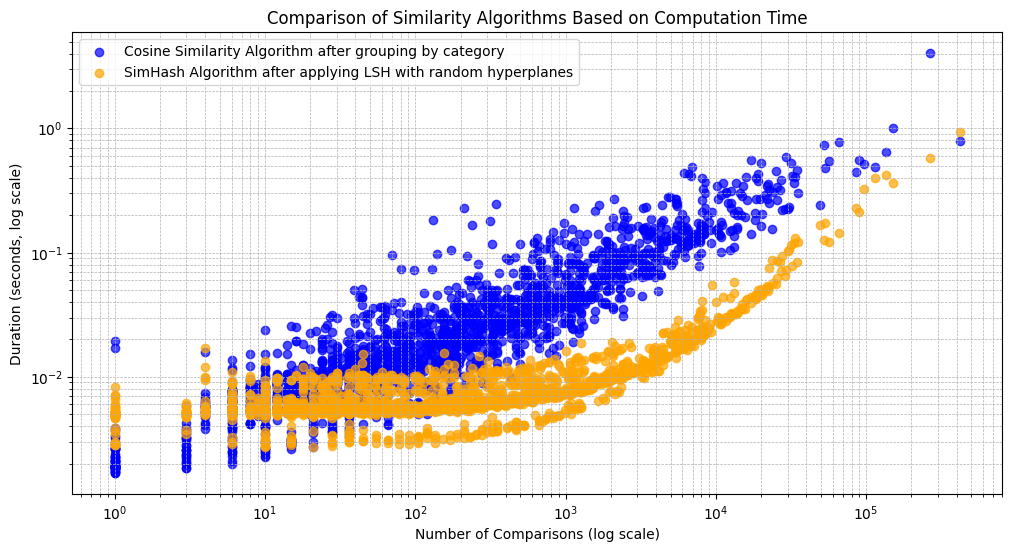

,Total Comparisons,Total Duration (seconds)
Cosine Similarity Algorithm after grouping by category,4371878,97.94
SimHash Algorithm after applying LSH with random hyperplanes,4371878,21.86


In [ ]:
# Custom names for algorithms
algo1_name = "Cosine Similarity Algorithm after grouping by category"
algo2_name = "SimHash Algorithm after applying LSH with random hyperplanes"

# Compute total durations and comparisons
total_duration_algo1 = round(duration_comparisons_combinations_Algorithm_1['Duration'].sum(), 2)
total_duration_algo2 = round(duration_comparisons_combinations_Algorithm_2['Duration'].sum(), 2)
total_comparisons_algo1 = int(duration_comparisons_combinations_Algorithm_1['Total_Comparisons'].sum())
total_comparisons_algo2 = int(duration_comparisons_combinations_Algorithm_2['Total_Comparisons'].sum())

# Create summary table
df_summary = pd.DataFrame({
    'Total Comparisons': [total_comparisons_algo1, total_comparisons_algo2],
    'Total Duration (seconds)': [total_duration_algo1, total_duration_algo2]
}, index=[algo1_name, algo2_name])

# Convert 'Total Comparisons' column to string without commas
df_summary['Total Comparisons'] = df_summary['Total Comparisons'].astype(str)

# Plot scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(duration_comparisons_combinations_Algorithm_1['Total_Comparisons'],
            duration_comparisons_combinations_Algorithm_1['Duration'],
            label=algo1_name, color='blue', alpha=0.7)
plt.scatter(duration_comparisons_combinations_Algorithm_2['Total_Comparisons'],
            duration_comparisons_combinations_Algorithm_2['Duration'],
            label=algo2_name, color='orange', alpha=0.7)

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Number of Comparisons (log scale)')
plt.ylabel('Duration (seconds, log scale)')
plt.title('Comparison of Similarity Algorithms Based on Computation Time')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

df_summary

Now, we aim to evaluate the trade-off between efficiency and accuracy by measuring how much precision is lost relative to an exhaustive similarity comparison across the entire dataset. To achieve this, we compare the recommendations generated by both algorithms with the recommendations generated by a brute-force method for 100 random products, to assess the performance of the algorithms in terms of retrieval quality. So, first step is compute the Cosine Similairty beteween these 100 products and all the other products and select only the first 20 most similar products for each of these 100.

In [ ]:
import hashlib

def create_rating_matrix(df):
    users, products = df['user_id'].unique(), df['product_id'].unique()
    user_idx = {u: i for i, u in enumerate(users)}
    product_idx = {p: i for i, p in enumerate(products)}

    rating_matrix = np.zeros((len(products), len(users)))
    for _, row in df.iterrows():
        rating_matrix[product_idx[row['product_id']], user_idx[row['user_id']]] = row['Rating']

    return rating_matrix, product_idx, products

# Create rating matrix and product mappings
rating_matrix, product_idx, unique_products = create_rating_matrix(filtered_ratings_user_products)

# Function to create a deterministic hash-based selection
def deterministic_sample(items, n):
    hashed_items = sorted(items, key=lambda x: int(hashlib.md5(str(x).encode()).hexdigest(), 16))
    return hashed_items[:n]

# Select 100 products using a hashing-based deterministic random approach
selected_products = deterministic_sample(list(product_idx.keys()), 100)

# Compute similarity and collect results
similarity_results = []
progress_bar = tqdm(selected_products, desc="Processing products", leave=True)

for product_id in progress_bar:
    if product_id not in product_idx:
        continue

    idx = product_idx[product_id]
    similarities = cosine_similarity(rating_matrix[idx].reshape(1, -1), rating_matrix)[0]

    temp_df = (
        pd.DataFrame({'recommended_product': unique_products, 'similarity': similarities})
        .query("similarity > 0.01 and recommended_product != @product_id")
        .nlargest(20, 'similarity')
        .assign(product_selected=product_id, Position=lambda x: range(1, len(x) + 1))
    )

    similarity_results.append(temp_df)

# Create final DataFrame
final_recommendations = pd.concat(similarity_results, ignore_index=True)
final_recommendations[['recommended_product', 'product_selected']] = final_recommendations[['recommended_product', 'product_selected']].astype(int)

final_recommendations

Processing products: 100%|██████████| 100/100 [08:12<00:00,  4.92s/it]


,recommended_product,similarity,product_selected,Position
0,12706854,0.333333,12717998,1
1,12711342,0.333333,12717998,2
2,12706983,0.327327,12717998,3
3,12712195,0.320256,12717998,4
4,12709040,0.320256,12717998,5
...,...,...,...,...
1857,28101562,0.254514,28100851,16
1858,28100733,0.254514,28100851,17
1859,28100544,0.245256,28100851,18
1860,28100894,0.236940,28100851,19


In [ ]:
# Ensure column names are consistent
final_recommendations.columns = final_recommendations.columns.str.strip()

# Create algorithms_comparison table
algorithms_comparison = final_recommendations.copy()

# Function to get top 20 similar products for a given selected product
def get_top_20_similar(df, selected_product):
    subset = df[(df['Product_1'] == selected_product) | (df['Product_2'] == selected_product)]
    top_20 = subset.nlargest(20, 'Similarity')
    return set(top_20['Product_1']).union(set(top_20['Product_2'])) - {selected_product}

# Compute top 10 similar products for each selected product
selected_products = final_recommendations['product_selected'].unique()
cosine_top_20 = {p: get_top_20_similar(products_similarity_after_grouping, p) for p in selected_products}
hamming_top_20 = {p: get_top_20_similar(products_similarity_after_LSH_hyperplanes, p) for p in selected_products}

# Assign values for Algorithm_with_Cosine
algorithms_comparison['Algorithm_with_Cosine'] = algorithms_comparison.apply(
    lambda row: 1 if row['recommended_product'] in cosine_top_20.get(row['product_selected'], set()) else 0, axis=1
)

# Assign values for Algorithm_with_Hamming
algorithms_comparison['Algorithm_with_Hamming'] = algorithms_comparison.apply(
    lambda row: 1 if row['recommended_product'] in hamming_top_20.get(row['product_selected'], set()) else 0, axis=1
)

algorithms_comparison

,recommended_product,similarity,product_selected,Position,Algorithm_with_Cosine,Algorithm_with_Hamming
0,12706854,0.333333,12717998,1,1,1
1,12711342,0.333333,12717998,2,1,1
2,12706983,0.327327,12717998,3,1,1
3,12712195,0.320256,12717998,4,1,0
4,12709040,0.320256,12717998,5,1,1
...,...,...,...,...,...,...
1857,28101562,0.254514,28100851,16,1,0
1858,28100733,0.254514,28100851,17,1,1
1859,28100544,0.245256,28100851,18,1,1
1860,28100894,0.236940,28100851,19,1,1


In the following charts, we first examine the histogram, which highlights that the second algorithm achieves good precision when the recommended products have a high actual similarity (exact cosine similarity > 0.4). However, this alone is not sufficient to ensure good overall performance. The subsequent bar charts further reveal that most recommended products tend to have only a moderate similarity score, limiting the effectiveness of the second algorithm. Finally, the scatter plots, where correct recommendations are marked in green and incorrect ones in red, make it evident that the first algorithm delivers significantly better results overall, achieving much higher precision in its recommendations.

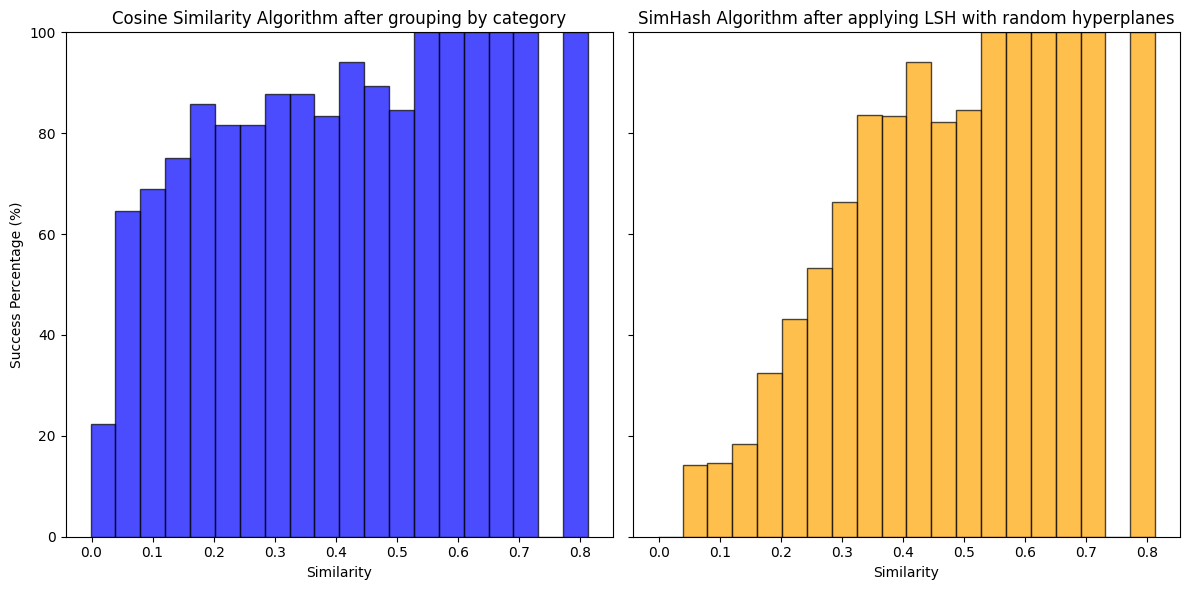

In [ ]:
# Define number of bins
bins = 20  # Number of bins for the histogram

# Compute histogram data for Cosine Similarity
hist_cosine, bin_edges = np.histogram(algorithms_comparison['similarity'], bins=bins)
correct_cosine, _ = np.histogram(algorithms_comparison[algorithms_comparison['Algorithm_with_Cosine'] == 1]['similarity'], bins=bin_edges)

# Avoid division by zero and invalid values
percent_cosine = np.zeros_like(hist_cosine, dtype=float)
nonzero_indices = hist_cosine > 0
percent_cosine[nonzero_indices] = (correct_cosine[nonzero_indices] / hist_cosine[nonzero_indices]) * 100

# Compute histogram data for Hamming Similarity
hist_hamming, bin_edges = np.histogram(algorithms_comparison['similarity'], bins=bins)
correct_hamming, _ = np.histogram(algorithms_comparison[algorithms_comparison['Algorithm_with_Hamming'] == 1]['similarity'], bins=bin_edges)

# Avoid division by zero and invalid values
percent_hamming = np.zeros_like(hist_hamming, dtype=float)
nonzero_indices = hist_hamming > 0
percent_hamming[nonzero_indices] = (correct_hamming[nonzero_indices] / hist_hamming[nonzero_indices]) * 100

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Histogram for Cosine Similarity
axes[0].bar(bin_edges[:-1], percent_cosine, width=np.diff(bin_edges), color='blue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Similarity')
axes[0].set_ylabel('Success Percentage (%)')
axes[0].set_title('Cosine Similarity Algorithm after grouping by category')
axes[0].set_ylim(0, 100)

# Histogram for Hamming Similarity
axes[1].bar(bin_edges[:-1], percent_hamming, width=np.diff(bin_edges), color='orange', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Similarity')
axes[1].set_title('SimHash Algorithm after applying LSH with random hyperplanes')
axes[1].set_ylim(0, 100)

# Show plot
plt.tight_layout()
plt.show()


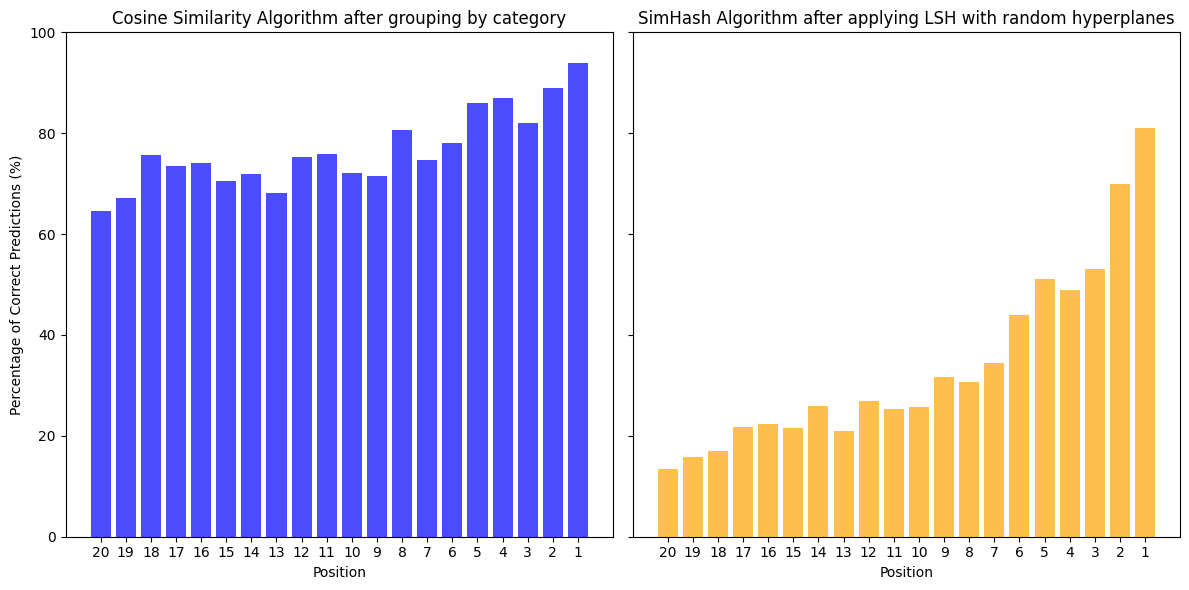

In [ ]:
# Calculate percentage of 1s for each position
position_counts_cosine = algorithms_comparison.groupby('Position')['Algorithm_with_Cosine'].mean() * 100
position_counts_hamming = algorithms_comparison.groupby('Position')['Algorithm_with_Hamming'].mean() * 100

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Bar plot for Cosine Similarity
axes[0].bar(position_counts_cosine.index, position_counts_cosine.values, color='blue', alpha=0.7)
axes[0].set_xlabel('Position')
axes[0].set_ylabel('Percentage of Correct Predictions (%)')
axes[0].set_title('Cosine Similarity Algorithm after grouping by category')
axes[0].set_xticks(range(1, 21))  # Set x-axis labels from 1 to 20
axes[0].set_ylim(0, 100)
axes[0].invert_xaxis()  # Invert X-axis

# Bar plot for Hamming Similarity
axes[1].bar(position_counts_hamming.index, position_counts_hamming.values, color='orange', alpha=0.7)
axes[1].set_xlabel('Position')
axes[1].set_title('SimHash Algorithm after applying LSH with random hyperplanes')
axes[1].set_xticks(range(1, 21))  # Set x-axis labels from 1 to 20
axes[1].set_ylim(0, 100)
axes[1].invert_xaxis()  # Invert X-axis

# Show plot
plt.tight_layout()
plt.show()


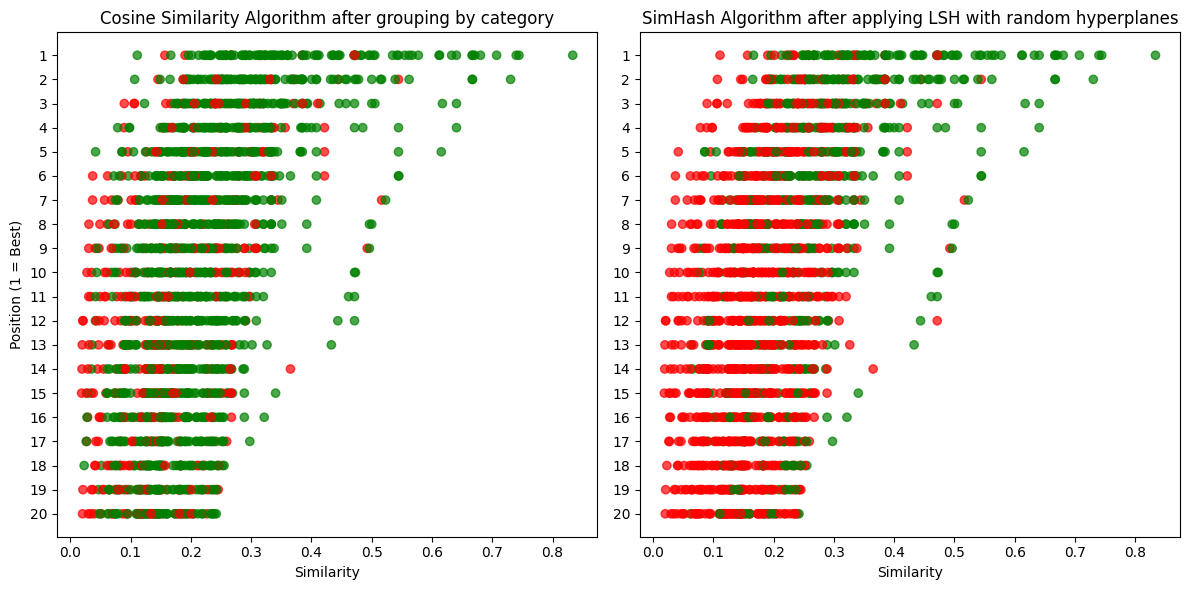

In [ ]:
# Set colors: green if correct (1), red if incorrect (0)
colors_cosine = algorithms_comparison['Algorithm_with_Cosine'].map({1: 'green', 0: 'red'})
colors_hamming = algorithms_comparison['Algorithm_with_Hamming'].map({1: 'green', 0: 'red'})  # Keep same color scheme

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True)

# Scatter plot for Cosine Similarity
axes[0].scatter(algorithms_comparison['similarity'], algorithms_comparison['Position'], c=colors_cosine, alpha=0.7)
axes[0].set_xlabel('Similarity')
axes[0].set_ylabel('Position (1 = Best)')
axes[0].set_title('Cosine Similarity Algorithm after grouping by category')
axes[0].invert_yaxis()  # Invert y-axis to have position 1 at the top
axes[0].set_yticks(range(1, 21, 1))  # Set y-axis labels every 5 positions

# Scatter plot for Hamming Similarity
axes[1].scatter(algorithms_comparison['similarity'], algorithms_comparison['Position'], c=colors_hamming, alpha=0.7)
axes[1].set_xlabel('Similarity')
axes[1].set_title('SimHash Algorithm after applying LSH with random hyperplanes')
axes[1].invert_yaxis()  # Invert y-axis to have position 1 at the top
axes[1].set_yticks(range(1, 21, 1))  # Set y-axis labels every 5 positions

# Show plot
plt.tight_layout()
plt.show()